In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
import tensorflow as tf
import time
import cv2

from IPython import display

from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
# from tensorflow.image import ssim

from matplotlib.colors import LinearSegmentedColormap


from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import structural_similarity as compare_ssim

# from scikit-mage.metrics import structural_similarity as ssim
# from skimage.metrics import mean_squared_error

In [2]:
# !pip install scikit-image

In [3]:
# # To generate GIFs
# # !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

In [4]:
pandas_version = pd.__version__
numpy_version = np.__version__
image_version = Image.__version__
# os_version = os.__version__
# matplot_version = plt.__version__
seaborn_version = sns.__version__
# matplot2_version = matplotlib.__version__
tensorflow_version = tf.__version__

print(f'Pandas version: {pandas_version}\nNumpy version: {numpy_version}\nImage version: {image_version}\nSeaborn version: {seaborn_version}\nTensorflow version: {tensorflow_version}')

Pandas version: 2.0.2
Numpy version: 1.23.5
Image version: 9.5.0
Seaborn version: 0.12.2
Tensorflow version: 2.13.0


In [5]:
IMG_PATH = 'D:/fashion-dataset/images'

In [6]:
# Read the styles.csv
style_columns = ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']
fashion_styles_df = pd.read_csv('D:/fashion-dataset/styles.csv', usecols=style_columns)
fashion_styles_df

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44441  17036    Men       Footwear       Shoes           Casual Shoes   
44442   6461    Men       Footwear  Flip Flops             Flip Flops   
44443  18842    Men        Apparel     Topwear                Tshirts   
44444  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44445  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44441      White  Summer  2013.0  Casual   
44442        Red  Summer  2011.0  Casual   
44443       Blue    Fall  2011.0  Casual   
44444       Blue  Spring  2017.0  Casual   
44445       Pink  Winter  2016.0  Casual   

                                    productDisplayName  
0                     Turtle Check Men Navy Blue Shirt  
1                   Peter England Men Party Blue Jeans  
2                             Titan Women Silver Watch  
3        Manchester United Men Solid Black Track Pants  
4                                Puma Men Grey T-shirt  
...                                                ...  
44441                        Gas Men Caddy Casual Shoe  
44442               Lotto Men's Soccer Track Flip Flop  
44443             Puma Men Graphic Stellar Blue Tshirt  
44444                   Rasasi Women Blue Lady Perfume  
44445  Fossil Women Pink Dial Chronograph Watch ES3050  

[44446 rows x 10 columns]

In [7]:
# checking the styles info
fashion_styles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44446 non-null  int64  
 1   gender              44446 non-null  object 
 2   masterCategory      44446 non-null  object 
 3   subCategory         44446 non-null  object 
 4   articleType         44446 non-null  object 
 5   baseColour          44431 non-null  object 
 6   season              44425 non-null  object 
 7   year                44445 non-null  float64
 8   usage               44129 non-null  object 
 9   productDisplayName  44439 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [8]:
# Read the image.csv
fashion_image_df = pd.read_csv('D:/fashion-dataset/images.csv')
fashion_image_df

filename                                               link
0      15970.jpg  http://assets.myntassets.com/v1/images/style/p...
1      39386.jpg  http://assets.myntassets.com/v1/images/style/p...
2      59263.jpg  http://assets.myntassets.com/v1/images/style/p...
3      21379.jpg  http://assets.myntassets.com/v1/images/style/p...
4      53759.jpg  http://assets.myntassets.com/v1/images/style/p...
...          ...                                                ...
44441  17036.jpg  http://assets.myntassets.com/v1/images/style/p...
44442   6461.jpg  http://assets.myntassets.com/v1/images/style/p...
44443  18842.jpg  http://assets.myntassets.com/v1/images/style/p...
44444  46694.jpg  http://assets.myntassets.com/v1/images/style/p...
44445  51623.jpg  http://assets.myntassets.com/assets/images/516...

[44446 rows x 2 columns]

In [9]:
# checking the images info
fashion_image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  44446 non-null  object
 1   link      44446 non-null  object
dtypes: object(2)
memory usage: 694.6+ KB


In [10]:
fashion_styles_df.masterCategory.unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care',
       'Free Items', 'Sporting Goods', 'Home'], dtype=object)

In [11]:
# Checking the unique values
fashion_styles_df.subCategory.unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts',
       'Flip Flops', 'Bags', 'Innerwear', 'Sandal', 'Shoe Accessories',
       'Fragrance', 'Jewellery', 'Lips', 'Saree', 'Eyewear', 'Nails',
       'Scarves', 'Dress', 'Loungewear and Nightwear', 'Wallets',
       'Apparel Set', 'Headwear', 'Mufflers', 'Skin Care', 'Makeup',
       'Free Gifts', 'Ties', 'Accessories', 'Skin', 'Beauty Accessories',
       'Water Bottle', 'Eyes', 'Bath and Body', 'Gloves',
       'Sports Accessories', 'Cufflinks', 'Sports Equipment', 'Stoles',
       'Hair', 'Perfumes', 'Home Furnishing', 'Umbrellas', 'Wristbands',
       'Vouchers'], dtype=object)

In [12]:
# Slicing the image filenames to create a new column called identity

fashion_image_df['identity'] = fashion_image_df['filename'].apply(lambda x: x[:-4])
fashion_image_df

filename                                               link identity
0      15970.jpg  http://assets.myntassets.com/v1/images/style/p...    15970
1      39386.jpg  http://assets.myntassets.com/v1/images/style/p...    39386
2      59263.jpg  http://assets.myntassets.com/v1/images/style/p...    59263
3      21379.jpg  http://assets.myntassets.com/v1/images/style/p...    21379
4      53759.jpg  http://assets.myntassets.com/v1/images/style/p...    53759
...          ...                                                ...      ...
44441  17036.jpg  http://assets.myntassets.com/v1/images/style/p...    17036
44442   6461.jpg  http://assets.myntassets.com/v1/images/style/p...     6461
44443  18842.jpg  http://assets.myntassets.com/v1/images/style/p...    18842
44444  46694.jpg  http://assets.myntassets.com/v1/images/style/p...    46694
44445  51623.jpg  http://assets.myntassets.com/assets/images/516...    51623

[44446 rows x 3 columns]

In [13]:
# checking the styles info
fashion_image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  44446 non-null  object
 1   link      44446 non-null  object
 2   identity  44446 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [14]:
# Converting the identity column to integer
fashion_image_df.identity = fashion_image_df.identity.astype(int)

In [15]:
# Merging both styles and image dataframes
fashion_df = pd.merge(fashion_styles_df, fashion_image_df, right_on='identity', left_on='id')
fashion_df

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44441  17036    Men       Footwear       Shoes           Casual Shoes   
44442   6461    Men       Footwear  Flip Flops             Flip Flops   
44443  18842    Men        Apparel     Topwear                Tshirts   
44444  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44445  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44441      White  Summer  2013.0  Casual   
44442        Red  Summer  2011.0  Casual   
44443       Blue    Fall  2011.0  Casual   
44444       Blue  Spring  2017.0  Casual   
44445       Pink  Winter  2016.0  Casual   

                                    productDisplayName   filename  \
0                     Turtle Check Men Navy Blue Shirt  15970.jpg   
1                   Peter England Men Party Blue Jeans  39386.jpg   
2                             Titan Women Silver Watch  59263.jpg   
3        Manchester United Men Solid Black Track Pants  21379.jpg   
4                                Puma Men Grey T-shirt  53759.jpg   
...                                                ...        ...   
44441                        Gas Men Caddy Casual Shoe  17036.jpg   
44442               Lotto Men's Soccer Track Flip Flop   6461.jpg   
44443             Puma Men Graphic Stellar Blue Tshirt  18842.jpg   
44444                   Rasasi Women Blue Lady Perfume  46694.jpg   
44445  Fossil Women Pink Dial Chronograph Watch ES3050  51623.jpg   

                                                    link  identity  
0      http://assets.myntassets.com/v1/images/style/p...     15970  
1      http://assets.myntassets.com/v1/images/style/p...     39386  
2      http://assets.myntassets.com/v1/images/style/p...     59263  
3      http://assets.myntassets.com/v1/images/style/p...     21379  
4      http://assets.myntassets.com/v1/images/style/p...     53759  
...                                                  ...       ...  
44441  http://assets.myntassets.com/v1/images/style/p...     17036  
44442  http://assets.myntassets.com/v1/images/style/p...      6461  
44443  http://assets.myntassets.com/v1/images/style/p...     18842  
44444  http://assets.myntassets.com/v1/images/style/p...     46694  
44445  http://assets.myntassets.com/assets/images/516...     51623  

[44446 rows x 13 columns]

In [16]:
# Ensuring the number of rows in fashion_df is equal to the number of pictures 
if len(os.listdir('D:/fashion-dataset/images')) == len(fashion_df):
    print(f"They are equal with {len(os.listdir('D:/fashion-dataset/images'))} images and filenames")
else:
    print(f"They are not equal. Pictures in folder are {len(os.listdir('D:/fashion-dataset/images'))} in number while number of info in dataframe is {len(fashion_df)}")

They are not equal. Pictures in folder are 44447 in number while number of info in dataframe is 44446


Please note: The code above indicates that some information in the dataframe do not have images in the fashion dataset folder. However there is a need to identify these information.

To do this, I need to search if each filename in the fashion_df dataframe exists in the image folder 

In [17]:
# Storing all the names of the images in the fashion-dataset folder into an array
images_name_list = os.listdir(IMG_PATH)
images_name_list

['10000.jpg',
 '10001.jpg',
 '10002.jpg',
 '10003.jpg',
 '10004.jpg',
 '10005.jpg',
 '10006.jpg',
 '10007.jpg',
 '10008.jpg',
 '10009.jpg',
 '10010.jpg',
 '10011.jpg',
 '10012.jpg',
 '10013.jpg',
 '10014.jpg',
 '10015.jpg',
 '10016.jpg',
 '10017.jpg',
 '10018.jpg',
 '10019.jpg',
 '10020.jpg',
 '10021.jpg',
 '10022.jpg',
 '10023.jpg',
 '10024.jpg',
 '10025.jpg',
 '10026.jpg',
 '10027.jpg',
 '10028.jpg',
 '10029.jpg',
 '10030.jpg',
 '10031.jpg',
 '10032.jpg',
 '10033.jpg',
 '10034.jpg',
 '10035.jpg',
 '10037.jpg',
 '10039.jpg',
 '10040.jpg',
 '10041.jpg',
 '10042.jpg',
 '10043.jpg',
 '10044.jpg',
 '10045.jpg',
 '10046.jpg',
 '10047.jpg',
 '10048.jpg',
 '10049.jpg',
 '10050.jpg',
 '10051.jpg',
 '10052.jpg',
 '10053.jpg',
 '10054.jpg',
 '10056.jpg',
 '10057.jpg',
 '10058.jpg',
 '10059.jpg',
 '10060.jpg',
 '10061.jpg',
 '10062.jpg',
 '10063.jpg',
 '10064.jpg',
 '10065.jpg',
 '10066.jpg',
 '10067.jpg',
 '10068.jpg',
 '10069.jpg',
 '10070.jpg',
 '10071.jpg',
 '10072.jpg',
 '10073.jpg',
 '1007

In [18]:
# Looping through to search for missing images
missing_images = []
for i in fashion_df['filename']:
    if i not in images_name_list:
        missing_images.append(i)
        
print(missing_images)

['39403.jpg', '39410.jpg', '39401.jpg', '39425.jpg', '12347.jpg']


In [19]:
# Getting more details of the missing images
fashion_df[fashion_df['filename'].isin(missing_images)]

id gender masterCategory subCategory articleType baseColour  season  \
6697   39403    Men        Apparel     Topwear      Shirts      Black  Summer   
16207  39410    Men        Apparel     Topwear      Shirts      Cream  Summer   
32324  39401    Men        Apparel  Bottomwear       Jeans       Blue  Winter   
36399  39425    Men        Apparel     Topwear     Tshirts        Red  Spring   
40022  12347    Men        Apparel     Topwear       Suits        Red  Winter   

         year   usage                                 productDisplayName  \
6697   2014.0  Casual  U.S. Polo Assn. Men Black Tailored Fit Casual ...   
16207  2014.0  Casual  U.S. Polo Assn. Men Cream-Coloured Tailored Fi...   
32324  2016.0  Casual  U.S. Polo Assn. Denim Co. Men Blue Slim Straig...   
36399  2013.0  Casual               U.S. Polo Assn. Men Red Polo T-Shirt   
40022  2010.0  Casual  Fastrack Men Red Manhattan Regular Fit Solid F...   

        filename       link  identity  
6697   39403.jpg  undefined     39403  
16207  39410.jpg  undefined     39410  
32324  39401.jpg  undefined     39401  
36399  39425.jpg  undefined     39425  
40022  12347.jpg  undefined     12347

In [20]:
# Getting clarity on the type of shirt it is. This is to know if the data is needed
fashion_df[fashion_df['masterCategory'].isin(['Apparel']) & fashion_df['gender'].isin(['Men'])]

id gender masterCategory subCategory  articleType baseColour  \
0      15970    Men        Apparel     Topwear       Shirts  Navy Blue   
1      39386    Men        Apparel  Bottomwear        Jeans       Blue   
3      21379    Men        Apparel  Bottomwear  Track Pants      Black   
4      53759    Men        Apparel     Topwear      Tshirts       Grey   
5       1855    Men        Apparel     Topwear      Tshirts       Grey   
...      ...    ...            ...         ...          ...        ...   
44429  32143    Men        Apparel   Innerwear       Briefs        Red   
44434   1644    Men        Apparel     Topwear      Tshirts        Red   
44436  30614    Men        Apparel     Topwear      Tshirts      Black   
44437  13496    Men        Apparel     Topwear      Tshirts       Blue   
44443  18842    Men        Apparel     Topwear      Tshirts       Blue   

       season    year   usage                             productDisplayName  \
0        Fall  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1      Summer  2012.0  Casual             Peter England Men Party Blue Jeans   
3        Fall  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4      Summer  2012.0  Casual                          Puma Men Grey T-shirt   
5      Summer  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt   
...       ...     ...     ...                                            ...   
44429  Summer  2016.0  Casual              Playboy Men Duet Pack of 2 Briefs   
44434    Fall  2010.0  Sports     Kipsta Men Loose Fit Round Neck Jersey Red   
44436  Summer  2012.0  Sports                  Nike Men Striped Black Jersey   
44437    Fall  2011.0  Casual          Chimp Men Teja Main Hoon Blue Tshirts   
44443    Fall  2011.0  Casual           Puma Men Graphic Stellar Blue Tshirt   

        filename                                               link  identity  
0      15970.jpg  http://assets.myntassets.com/v1/images/style/p...     15970  
1      39386.jpg  http://assets.myntassets.com/v1/images/style/p...     39386  
3      21379.jpg  http://assets.myntassets.com/v1/images/style/p...     21379  
4      53759.jpg  http://assets.myntassets.com/v1/images/style/p...     53759  
5       1855.jpg  http://assets.myntassets.com/v1/images/style/p...      1855  
...          ...                                                ...       ...  
44429  32143.jpg  http://assets.myntassets.com/v1/images/style/p...     32143  
44434   1644.jpg  http://assets.myntassets.com/v1/images/style/p...      1644  
44436  30614.jpg  http://assets.myntassets.com/v1/images/style/p...     30614  
44437  13496.jpg  http://assets.myntassets.com/v1/images/style/p...     13496  
44443  18842.jpg  http://assets.myntassets.com/v1/images/style/p...     18842  

[11355 rows x 13 columns]

In [21]:
# Dropping the missing images after I realized it is not needed for generating new images
fashion_df.drop(index=[6697, 16207, 32324, 36399, 40022], inplace=True)

In [22]:
# Viewing the information of my dataframe
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44441 entries, 0 to 44445
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44441 non-null  int64  
 1   gender              44441 non-null  object 
 2   masterCategory      44441 non-null  object 
 3   subCategory         44441 non-null  object 
 4   articleType         44441 non-null  object 
 5   baseColour          44426 non-null  object 
 6   season              44420 non-null  object 
 7   year                44440 non-null  float64
 8   usage               44124 non-null  object 
 9   productDisplayName  44434 non-null  object 
 10  filename            44441 non-null  object 
 11  link                44441 non-null  object 
 12  identity            44441 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(10)
memory usage: 4.6+ MB


In [23]:
# Re-checking to ensure the number of rows in fashion_df is equal to the number of pictures 
if len(os.listdir(IMG_PATH)) == len(fashion_df):
    print(f"They are equal with {len(os.listdir(IMG_PATH))} images and filenames")
else:
    print(f"They are not equal. Pictures in folder are {len(os.listdir(IMG_PATH))} in number while number of info in dataframe is {len(fashion_df)}")

They are not equal. Pictures in folder are 44447 in number while number of info in dataframe is 44441


### Handling NaN values

In [24]:
# Searching for NaN values
fashion_df.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
identity                0
dtype: int64

In [25]:
# Searching for possible empty strings
fashion_df.isin(['',' ']).sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
filename              0
link                  0
identity              0
dtype: int64

#### Cleaning the baseColour column

In [26]:
# Identifying the data with the missing colours
fashion_df[fashion_df['baseColour'].isna()]

id gender masterCategory subCategory            articleType  \
6207   11293    Men        Apparel  Bottomwear                  Jeans   
9521   41347    Men        Apparel  Bottomwear                  Jeans   
12773  11288    Men        Apparel  Bottomwear                  Jeans   
14302  30991  Women  Personal Care   Fragrance  Perfume and Body Mist   
15539  57698  Women  Personal Care        Skin      Face Moisturisers   
15721  41355    Men        Apparel  Bottomwear                  Jeans   
17281  43122    Men  Personal Care   Fragrance  Perfume and Body Mist   
17652  45687    Men  Personal Care   Fragrance  Perfume and Body Mist   
20222  11309    Men        Apparel  Bottomwear                  Jeans   
23497  45698  Women  Personal Care   Fragrance  Perfume and Body Mist   
34569  41357    Men        Apparel  Bottomwear                  Jeans   
37549  30992    Men  Personal Care   Fragrance  Perfume and Body Mist   
40697  43119    Men  Personal Care   Fragrance  Perfume and Body Mist   
43282  43116  Women  Personal Care   Fragrance  Perfume and Body Mist   
44246  43120    Men  Personal Care   Fragrance  Perfume and Body Mist   

      baseColour  season    year   usage  \
6207         NaN    Fall  2016.0  Casual   
9521         NaN    Fall  2016.0  Casual   
12773        NaN    Fall  2016.0  Casual   
14302        NaN  Spring  2017.0     NaN   
15539        NaN  Spring  2017.0  Casual   
15721        NaN    Fall  2016.0  Casual   
17281        NaN  Spring  2017.0     NaN   
17652        NaN  Spring  2017.0     NaN   
20222        NaN    Fall  2016.0  Casual   
23497        NaN  Spring  2017.0     NaN   
34569        NaN    Fall  2016.0  Casual   
37549        NaN  Spring  2017.0     NaN   
40697        NaN  Spring  2017.0     NaN   
43282        NaN  Spring  2017.0     NaN   
44246        NaN  Spring  2017.0     NaN   

                                      productDisplayName   filename  \
6207                       Wrangler Men Blue Texas Jeans  11293.jpg   
9521                      Wrangler Men Black Texas Jeans  41347.jpg   
12773                      Wrangler Men Blue Texas Jeans  11288.jpg   
14302                                                NaN  30991.jpg   
15539  Lotus Herbals Quincenourish Quince Seed Nouris...  57698.jpg   
15721                    Wrangler Men Blue Millard Jeans  41355.jpg   
17281                    GUESS Man Eau De Toilette 75 ml  43122.jpg   
17652                                                NaN  45687.jpg   
20222                      Wrangler Men Blue Floyd Jeans  11309.jpg   
23497                                                NaN  45698.jpg   
34569                    Wrangler Men Blue Millard Jeans  41357.jpg   
37549                                                NaN  30992.jpg   
40697                                                NaN  43119.jpg   
43282                    GUESS Seductive Women EDT Spray  43116.jpg   
44246        GUESS by Marciano Men Eau De Toilette 50 ml  43120.jpg   

                                                    link  identity  
6207   http://assets.myntassets.com/v1/images/style/p...     11293  
9521   http://assets.myntassets.com/v1/images/style/p...     41347  
12773  http://assets.myntassets.com/v1/images/style/p...     11288  
14302  http://assets.myntassets.com/assets/images/309...     30991  
15539  http://assets.myntassets.com/assets/images/576...     57698  
15721  http://assets.myntassets.com/v1/images/style/p...     41355  
17281  http://assets.myntassets.com/assets/images/431...     43122  
17652  http://assets.myntassets.com/assets/images/456...     45687  
20222  http://assets.myntassets.com/v1/images/style/p...     11309  
23497  http://assets.myntassets.com/assets/images/456...     45698  
34569  http://assets.myntassets.com/v1/images/style/p...     41357  
37549  http://assets.myntassets.com/assets/images/309...     30992  
40697  http://assets.myntassets.com/assets/images/431...     43119  
43282  http://assets.myntassets.c

In [27]:
# Putting the filenames of the missing colours in an array
missing_colours_name = []
missing_colours = fashion_df[fashion_df['baseColour'].isna()]
for i in missing_colours['filename']:
    missing_colours_name.append(i)

In [28]:
# Confirming the filenames of the missing colours in an array
missing_colours_name

['11293.jpg',
 '41347.jpg',
 '11288.jpg',
 '30991.jpg',
 '57698.jpg',
 '41355.jpg',
 '43122.jpg',
 '45687.jpg',
 '11309.jpg',
 '45698.jpg',
 '41357.jpg',
 '30992.jpg',
 '43119.jpg',
 '43116.jpg',
 '43120.jpg']

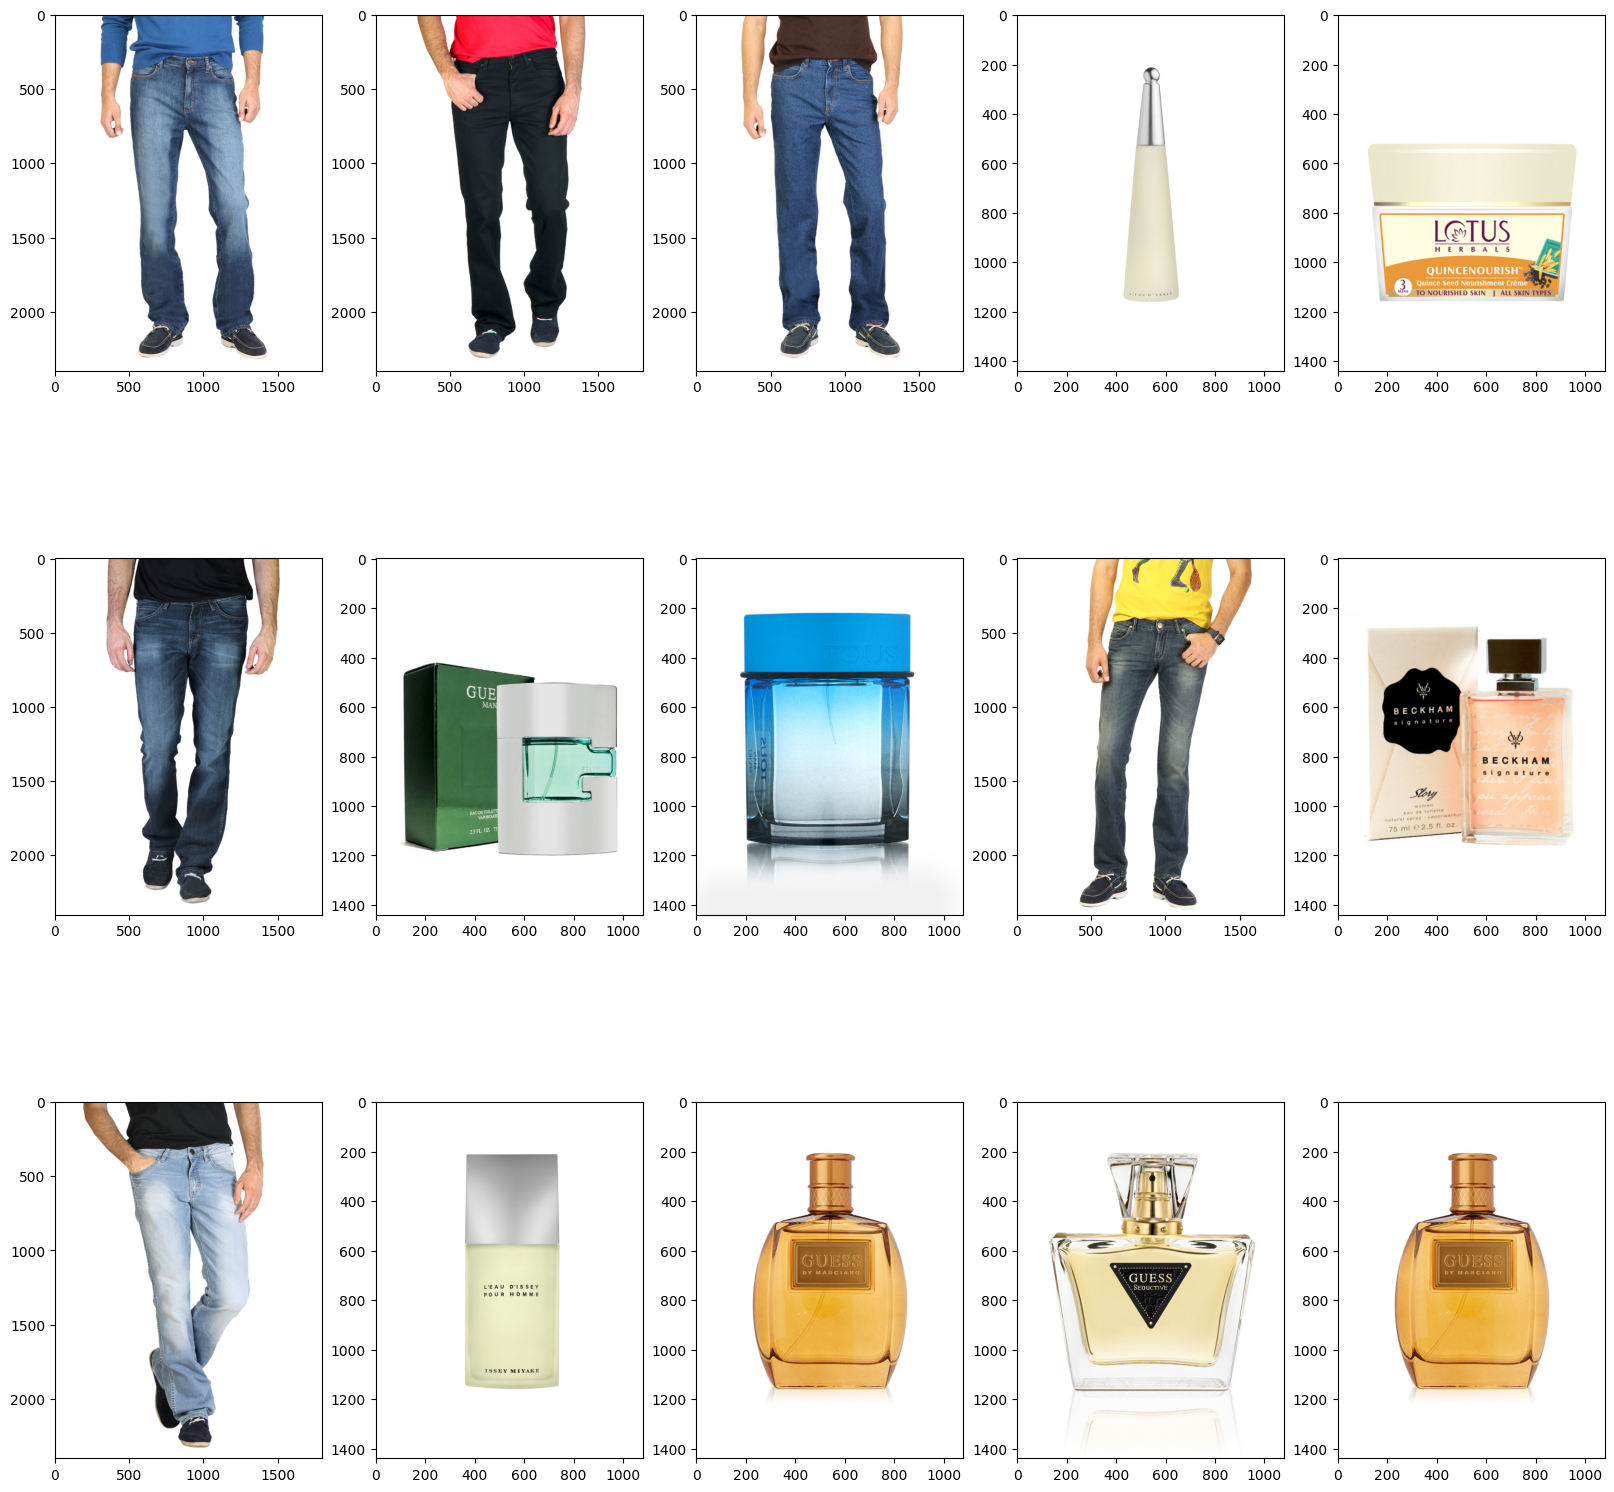

In [29]:
# visualizing the images with missing colours
plt.figure(figsize=(20,20))

for i in range(len(missing_colours_name)):
    plt.subplot(3, 5, i+1)
    image = plt.imread(IMG_PATH +'/'+ missing_colours_name[i])
    plt.imshow(image)
    fashion_name = fashion_df.subCategory.where(fashion_df.filename == i)
#     plt.title(fashion_name)
    
plt.show()

In [30]:
fashion_name = fashion_df.subCategory[fashion_df.filename == '43116.jpg']
fashion_name

43282    Fragrance
Name: subCategory, dtype: object

In [31]:
fashion_df.baseColour.unique()

array(['Navy Blue', 'Blue', 'Silver', 'Black', 'Grey', 'Green', 'Purple',
       'White', 'Beige', 'Brown', 'Bronze', 'Teal', 'Copper', 'Pink',
       'Off White', 'Maroon', 'Red', 'Khaki', 'Orange', 'Coffee Brown',
       'Yellow', 'Charcoal', 'Gold', 'Steel', 'Tan', 'Multi', 'Magenta',
       'Lavender', 'Sea Green', 'Cream', 'Peach', 'Olive', 'Skin',
       'Burgundy', 'Grey Melange', 'Rust', 'Rose', 'Lime Green', 'Mauve',
       'Turquoise Blue', 'Metallic', 'Mustard', 'Taupe', 'Nude',
       'Mushroom Brown', nan, 'Fluorescent Green'], dtype=object)

In [32]:
# Assigning the correct colours to the possible products
fashion_df.at[6207, 'baseColour'] = 'Blue'	
fashion_df.at[9521, 'baseColour'] = 'Black'
fashion_df.at[12773, 'baseColour'] = 'Blue'
fashion_df.at[14302, 'baseColour'] = 'Cream'
fashion_df.at[15539, 'baseColour'] = 'Cream'
fashion_df.at[15721, 'baseColour'] = 'Navy Blue'
fashion_df.at[17281, 'baseColour'] = 'Fluorescent Green'
fashion_df.at[17652, 'baseColour'] = 'Blue'
fashion_df.at[20222, 'baseColour'] = 'Grey'
fashion_df.at[23497, 'baseColour'] = 'Beige'
fashion_df.at[34569, 'baseColour'] = 'Turquoise Blue'
fashion_df.at[37549, 'baseColour'] = 'off white'
fashion_df.at[40697, 'baseColour'] = 'Gold'
fashion_df.at[43282, 'baseColour'] = 'Cream'
fashion_df.at[44246, 'baseColour'] = 'Gold'

In [33]:
fashion_df.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour              0
season                 21
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
identity                0
dtype: int64

#### Cleaning the season column

In [34]:
# Identifying the data with the missing season
missing_season = fashion_df[fashion_df['season'].isna()]
missing_season

id  gender masterCategory subCategory   articleType baseColour  \
282     5402   Women       Footwear       Shoes  Sports Shoes     Purple   
5997    5389  Unisex       Footwear       Shoes  Sports Shoes     Yellow   
6511    5380   Women       Footwear       Shoes  Sports Shoes     Purple   
12668   5392  Unisex       Footwear       Shoes  Sports Shoes      White   
13004   5361     Men       Footwear       Shoes  Sports Shoes      Black   
13533   5368     Men       Footwear       Shoes  Sports Shoes        Red   
16055   5360   Women       Footwear       Shoes  Sports Shoes       Grey   
21285  53781     Men        Apparel     Topwear       Tshirts       Blue   
23848   5406   Women       Footwear       Shoes  Sports Shoes       Blue   
24211   5401   Women       Footwear       Shoes  Sports Shoes       Blue   
27738   5407   Women       Footwear       Shoes  Sports Shoes      Beige   
30127   5370     Men       Footwear       Shoes  Sports Shoes      Black   
30459   5377  Unisex       Footwear       Shoes  Sports Shoes      Black   
32261   5376  Unisex       Footwear       Shoes  Sports Shoes      Black   
32630   5385   Women       Footwear       Shoes  Sports Shoes       Blue   
33707   5365  Unisex       Footwear       Shoes  Sports Shoes      Green   
33868   5391     Men       Footwear       Shoes  Sports Shoes       Blue   
34373   5398     Men       Footwear       Shoes  Sports Shoes       Grey   
34535   5354     Men       Footwear       Shoes  Sports Shoes       Grey   
36139   5355     Men       Footwear       Shoes  Sports Shoes       Grey   
36892   5390  Unisex       Footwear       Shoes  Sports Shoes       Grey   

      season    year   usage                      productDisplayName  \
282      NaN  2011.0  Sports       Kalenji Ekiden 200 Wn Purple 2011   
5997     NaN  2011.0  Sports          Kalenji Kapteren 200 Yellow Fw   
6511     NaN  2011.0  Sports         Quechua Forclaz 100 Lady Purple   
12668    NaN  2011.0  Sports         Kalenji Crossport 100 Whi/champ   
13004    NaN  2011.0  Sports                  Kipsta F300 Fg Sr Ah09   
13533    NaN  2011.0  Sports      Kalenji Kiprun 1000 White Red Ss10   
16055    NaN  2011.0  Sports          Kalenji Kapteren 100 Blue/grey   
21285    NaN     NaN  Sports  Puma Men Blue Sless Round Neck T-shirt   
23848    NaN  2011.0  Sports        Kalenji Ekiden Blue Scratch 2011   
24211    NaN  2011.0  Sports      Kalenji Ekiden 100  Lady Blue 2011   
27738    NaN  2011.0  Sports          Quechua Forclaz 500 L Beige Cn   
30127    NaN  2011.0  Sports              Inesis Canaveral 700 Black   
30459    NaN  2011.0  Sports                      Btwin Road Shoes 5   
32261    NaN  2011.0  Sports                       Btwin Mtb Shoes 7   
32630    NaN  2011.0  Sports         Quechua Arpenaz Flex  Lady Grey   
33707    NaN  2011.0  Sports                Solognac Shoes Namib 200   
33868    NaN  2011.0  Sports           Kalenji Kiprun 2000 Blue Ah10   
34373    NaN  2011.0  Sports       Quechua Arpenaz Flex Novadry Grey   
34535    NaN  2011.0  Sports           Kalenji Ekiden 50 Wht/grey 09   
36139    NaN  2011.0  Sports         Kalenji Kapteren 100 Grey/white   
36892    NaN  2011.0  Sports         Kalenji Kapteren 100 Grey Orang   

        filename                                               link  identity  
282     5402.jpg  http://assets.myntassets.com/v1/images/style/p...      5402  
5997    5389.jpg  http://assets.myntassets.com/v1/images/style/p...      5389  
6511    5380.jpg  http://assets.myntassets.com/v1/images/style/p...      5380  
12668   5392.jpg  http://assets.myntassets.com/v1/images/style/p...      5392  
13004   5361.jpg  http://assets.myntassets.com/v1/images/style/p...      5361  
13533   5368.jpg  http://assets.myntassets.com/v1/images/style/p...      5368  
16055   5360.jpg  http://assets.myntassets.com/v1/images/style/p...      5360  
21285  53781.jpg  http://assets.myntassets.com/assets/images/537...     53781  
23848   5406.jpg  http://assets.

In [35]:
# Verifying the number of items with missing season names
len(missing_season)

21

In [36]:
# Checking the seasons available
fashion_df['season'].unique()

array(['Fall', 'Summer', 'Winter', 'Spring', nan], dtype=object)

In [37]:
# Putting the filenames of the images with missing season in an array
missing_season_name = []
for i in missing_season['filename']:
    missing_season_name.append(i)

In [38]:
print(missing_season_name, f'{len(missing_season_name)} with missing seasons')

['5402.jpg', '5389.jpg', '5380.jpg', '5392.jpg', '5361.jpg', '5368.jpg', '5360.jpg', '53781.jpg', '5406.jpg', '5401.jpg', '5407.jpg', '5370.jpg', '5377.jpg', '5376.jpg', '5385.jpg', '5365.jpg', '5391.jpg', '5398.jpg', '5354.jpg', '5355.jpg', '5390.jpg'] 21 with missing seasons


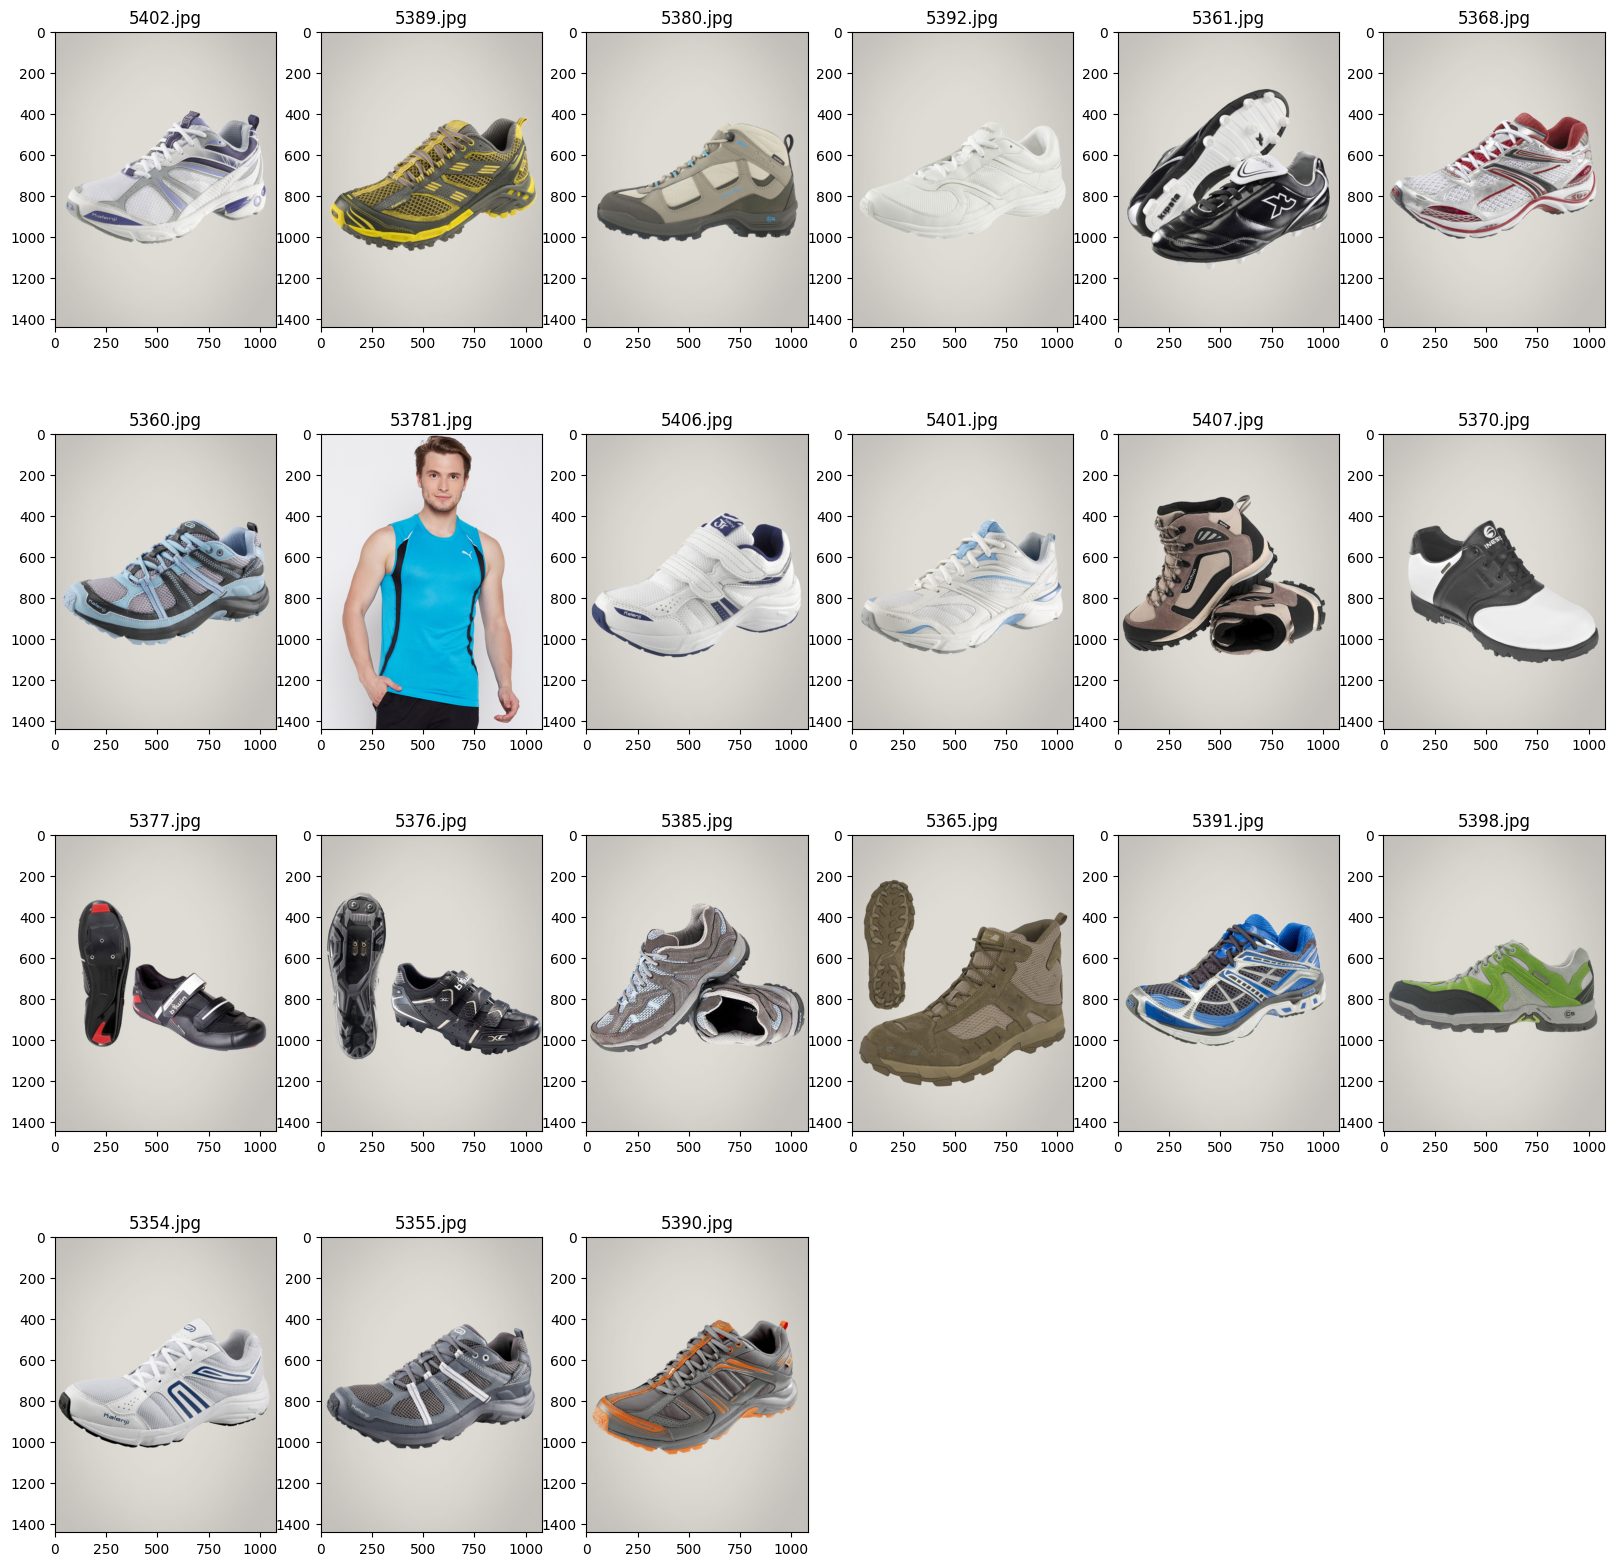

In [39]:
# viewing the images with missing seasons
plt.figure(figsize=(20,20))

for i in range(len(missing_season_name)):
    plt.subplot(4, 6, i+1)
    image = plt.imread(IMG_PATH +'/'+ missing_season_name[i])
    plt.imshow(image)
#     fashion_name = fashion_df.subCategory[fashion_df.filename == i]
    plt.title(missing_season_name[i])
    
plt.show()

After viewing the images, it was realized that most of the images without the 'season' values were sport shoes. Having established this, i decided to assign the mode of the season for sport shoes to the missing sport shoes

In [40]:
# Getting all sport shoes in the dataframe
sports_shoes = fashion_df[fashion_df['articleType'] == 'Sports Shoes']
sports_shoes

id gender masterCategory subCategory   articleType baseColour  \
45      3168    Men       Footwear       Shoes  Sports Shoes      White   
67      6628    Men       Footwear       Shoes  Sports Shoes      White   
89     33822    Men       Footwear       Shoes  Sports Shoes      White   
103    42089    Men       Footwear       Shoes  Sports Shoes      White   
108    23882    Men       Footwear       Shoes  Sports Shoes       Grey   
...      ...    ...            ...         ...           ...        ...   
44304  25564    Men       Footwear       Shoes  Sports Shoes      White   
44327  31958    Men       Footwear       Shoes  Sports Shoes       Grey   
44352  15305    Men       Footwear       Shoes  Sports Shoes      White   
44392   4560    Men       Footwear       Shoes  Sports Shoes      White   
44426   4336    Men       Footwear       Shoes  Sports Shoes      White   

       season    year   usage                         productDisplayName  \
45       Fall  2010.0  Sports  Nike Men's Incinerate MSL White Blue Shoe   
67     Summer  2011.0  Sports      ADIDAS Men's Lowell White Silver Shoe   
89     Summer  2012.0  Sports    Puma Men Axis White & Grey Sports Shoes   
103    Summer  2012.0  Sports       ADIDAS Men White Corona Sports Shoes   
108      Fall  2011.0  Sports         Fila Men Destiny Grey Sports Shoes   
...       ...     ...     ...                                        ...   
44304  Summer  2012.0  Sports          Fila Men Swift White Sports Shoes   
44327  Summer  2012.0  Sports      Nike Men Revolution Grey Sports Shoes   
44352    Fall  2011.0  Sports     ADIDAS Men Aerostar White Sports Shoes   
44392  Summer  2011.0  Sports             Nike Men's Dunk Low White Shoe   
44426  Summer  2011.0  Sports        Fila Men's Leonard White Black Shoe   

        filename                                               link  identity  
45      3168.jpg  http://assets.myntassets.com/v1/images/style/p...      3168  
67      6628.jpg  http://assets.myntassets.com/v1/images/style/p...      6628  
89     33822.jpg  http://assets.myntassets.com/v1/images/style/p...     33822  
103    42089.jpg  http://assets.myntassets.com/v1/images/style/p...     42089  
108    23882.jpg  http://assets.myntassets.com/v1/images/style/p...     23882  
...          ...                                                ...       ...  
44304  25564.jpg  http://assets.myntassets.com/v1/images/style/p...     25564  
44327  31958.jpg  http://assets.myntassets.com/v1/images/style/p...     31958  
44352  15305.jpg  http://assets.myntassets.com/v1/images/style/p...     15305  
44392   4560.jpg  http://assets.myntassets.com/v1/images/style/p...      4560  
44426   4336.jpg  http://assets.myntassets.com/v1/images/style/p...      4336  

[2036 rows x 13 columns]

In [41]:
# Getting the total number of sports shoes per season 
sports_shoes['season'].value_counts()

season
Summer    1191
Fall       724
Spring      89
Winter      12
Name: count, dtype: int64

In [42]:
# sports_shoes['season']

<Axes: xlabel='season', ylabel='count'>

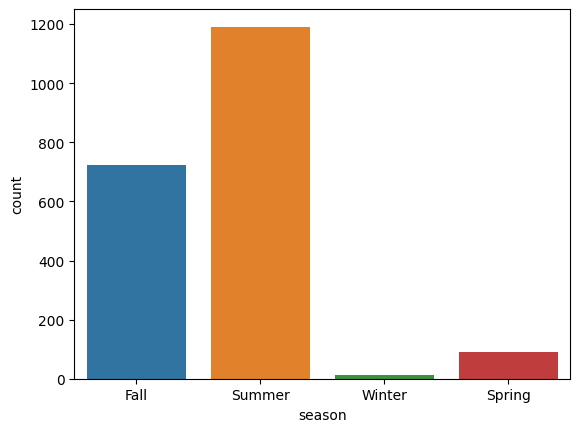

In [43]:
# Plotting the graph for sports shoes
sns.countplot(sports_shoes, x='season')

In [44]:
# fig, ax = plt.subplots()

# ax.bar(data=sports_shoes, x='season')
# plt.show()

In [45]:
sports_shoes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2036 entries, 45 to 44426
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2036 non-null   int64  
 1   gender              2036 non-null   object 
 2   masterCategory      2036 non-null   object 
 3   subCategory         2036 non-null   object 
 4   articleType         2036 non-null   object 
 5   baseColour          2036 non-null   object 
 6   season              2016 non-null   object 
 7   year                2036 non-null   float64
 8   usage               2036 non-null   object 
 9   productDisplayName  2036 non-null   object 
 10  filename            2036 non-null   object 
 11  link                2036 non-null   object 
 12  identity            2036 non-null   int32  
dtypes: float64(1), int32(1), int64(1), object(10)
memory usage: 214.7+ KB


In [46]:
# Getting all the shoes with missing seasons 
missing_season[missing_season['subCategory'] == 'Shoes']

id  gender masterCategory subCategory   articleType baseColour  \
282    5402   Women       Footwear       Shoes  Sports Shoes     Purple   
5997   5389  Unisex       Footwear       Shoes  Sports Shoes     Yellow   
6511   5380   Women       Footwear       Shoes  Sports Shoes     Purple   
12668  5392  Unisex       Footwear       Shoes  Sports Shoes      White   
13004  5361     Men       Footwear       Shoes  Sports Shoes      Black   
13533  5368     Men       Footwear       Shoes  Sports Shoes        Red   
16055  5360   Women       Footwear       Shoes  Sports Shoes       Grey   
23848  5406   Women       Footwear       Shoes  Sports Shoes       Blue   
24211  5401   Women       Footwear       Shoes  Sports Shoes       Blue   
27738  5407   Women       Footwear       Shoes  Sports Shoes      Beige   
30127  5370     Men       Footwear       Shoes  Sports Shoes      Black   
30459  5377  Unisex       Footwear       Shoes  Sports Shoes      Black   
32261  5376  Unisex       Footwear       Shoes  Sports Shoes      Black   
32630  5385   Women       Footwear       Shoes  Sports Shoes       Blue   
33707  5365  Unisex       Footwear       Shoes  Sports Shoes      Green   
33868  5391     Men       Footwear       Shoes  Sports Shoes       Blue   
34373  5398     Men       Footwear       Shoes  Sports Shoes       Grey   
34535  5354     Men       Footwear       Shoes  Sports Shoes       Grey   
36139  5355     Men       Footwear       Shoes  Sports Shoes       Grey   
36892  5390  Unisex       Footwear       Shoes  Sports Shoes       Grey   

      season    year   usage                  productDisplayName  filename  \
282      NaN  2011.0  Sports   Kalenji Ekiden 200 Wn Purple 2011  5402.jpg   
5997     NaN  2011.0  Sports      Kalenji Kapteren 200 Yellow Fw  5389.jpg   
6511     NaN  2011.0  Sports     Quechua Forclaz 100 Lady Purple  5380.jpg   
12668    NaN  2011.0  Sports     Kalenji Crossport 100 Whi/champ  5392.jpg   
13004    NaN  2011.0  Sports              Kipsta F300 Fg Sr Ah09  5361.jpg   
13533    NaN  2011.0  Sports  Kalenji Kiprun 1000 White Red Ss10  5368.jpg   
16055    NaN  2011.0  Sports      Kalenji Kapteren 100 Blue/grey  5360.jpg   
23848    NaN  2011.0  Sports    Kalenji Ekiden Blue Scratch 2011  5406.jpg   
24211    NaN  2011.0  Sports  Kalenji Ekiden 100  Lady Blue 2011  5401.jpg   
27738    NaN  2011.0  Sports      Quechua Forclaz 500 L Beige Cn  5407.jpg   
30127    NaN  2011.0  Sports          Inesis Canaveral 700 Black  5370.jpg   
30459    NaN  2011.0  Sports                  Btwin Road Shoes 5  5377.jpg   
32261    NaN  2011.0  Sports                   Btwin Mtb Shoes 7  5376.jpg   
32630    NaN  2011.0  Sports     Quechua Arpenaz Flex  Lady Grey  5385.jpg   
33707    NaN  2011.0  Sports            Solognac Shoes Namib 200  5365.jpg   
33868    NaN  2011.0  Sports       Kalenji Kiprun 2000 Blue Ah10  5391.jpg   
34373    NaN  2011.0  Sports   Quechua Arpenaz Flex Novadry Grey  5398.jpg   
34535    NaN  2011.0  Sports       Kalenji Ekiden 50 Wht/grey 09  5354.jpg   
36139    NaN  2011.0  Sports     Kalenji Kapteren 100 Grey/white  5355.jpg   
36892    NaN  2011.0  Sports     Kalenji Kapteren 100 Grey Orang  5390.jpg   

                                                    link  identity  
282    http://assets.myntassets.com/v1/images/style/p...      5402  
5997   http://assets.myntassets.com/v1/images/style/p...      5389  
6511   http://assets.myntassets.com/v1/images/style/p...      5380  
12668  http://assets.myntassets.com/v1/images/style/p...      5392  
13004  http://assets.myntassets.com/v1/images/style/p...      5361  
13533  http://assets.myntassets.com/v1/images/style/p...      5368  
16055  http://assets.myntassets.com/v1/images/style/p...      5360  
23848  http://assets.myntassets.com/v1/images/style/p...      5406  
24211  http://assets.myntassets.com/v1/images/style/p...      5401  
27738  http://assets.myntassets.com/v1/images/style/p...      5407  
30127  http://assets.myntassets.com

In [47]:
# Getting the total number of shoes with missing seasons
len(missing_season[missing_season['subCategory'] == 'Shoes'])

20

In [48]:
# Getting the index of shoes with missing seasons
(missing_season[missing_season['subCategory'] == 'Shoes']).index

Index([  282,  5997,  6511, 12668, 13004, 13533, 16055, 23848, 24211, 27738,
       30127, 30459, 32261, 32630, 33707, 33868, 34373, 34535, 36139, 36892],
      dtype='int64')

In [49]:
# Getting the mode of the sport shoes
sports_shoes.season.mode()[0]

'Summer'

In [50]:
# Replacing the missing seasons of sports shoes with the mode of seasons
sport_shoes_index = (missing_season[missing_season['subCategory'] == 'Shoes']).index
for i in sport_shoes_index:
    fashion_df.at[i, 'season'] = sports_shoes.season.mode()[0]

In [51]:

fashion_df.iloc[282]

id                                                                 5402
gender                                                            Women
masterCategory                                                 Footwear
subCategory                                                       Shoes
articleType                                                Sports Shoes
baseColour                                                       Purple
season                                                           Summer
year                                                             2011.0
usage                                                            Sports
productDisplayName                    Kalenji Ekiden 200 Wn Purple 2011
filename                                                       5402.jpg
link                  http://assets.myntassets.com/v1/images/style/p...
identity                                                           5402
Name: 282, dtype: object

In [52]:
missing_season

id  gender masterCategory subCategory   articleType baseColour  \
282     5402   Women       Footwear       Shoes  Sports Shoes     Purple   
5997    5389  Unisex       Footwear       Shoes  Sports Shoes     Yellow   
6511    5380   Women       Footwear       Shoes  Sports Shoes     Purple   
12668   5392  Unisex       Footwear       Shoes  Sports Shoes      White   
13004   5361     Men       Footwear       Shoes  Sports Shoes      Black   
13533   5368     Men       Footwear       Shoes  Sports Shoes        Red   
16055   5360   Women       Footwear       Shoes  Sports Shoes       Grey   
21285  53781     Men        Apparel     Topwear       Tshirts       Blue   
23848   5406   Women       Footwear       Shoes  Sports Shoes       Blue   
24211   5401   Women       Footwear       Shoes  Sports Shoes       Blue   
27738   5407   Women       Footwear       Shoes  Sports Shoes      Beige   
30127   5370     Men       Footwear       Shoes  Sports Shoes      Black   
30459   5377  Unisex       Footwear       Shoes  Sports Shoes      Black   
32261   5376  Unisex       Footwear       Shoes  Sports Shoes      Black   
32630   5385   Women       Footwear       Shoes  Sports Shoes       Blue   
33707   5365  Unisex       Footwear       Shoes  Sports Shoes      Green   
33868   5391     Men       Footwear       Shoes  Sports Shoes       Blue   
34373   5398     Men       Footwear       Shoes  Sports Shoes       Grey   
34535   5354     Men       Footwear       Shoes  Sports Shoes       Grey   
36139   5355     Men       Footwear       Shoes  Sports Shoes       Grey   
36892   5390  Unisex       Footwear       Shoes  Sports Shoes       Grey   

      season    year   usage                      productDisplayName  \
282      NaN  2011.0  Sports       Kalenji Ekiden 200 Wn Purple 2011   
5997     NaN  2011.0  Sports          Kalenji Kapteren 200 Yellow Fw   
6511     NaN  2011.0  Sports         Quechua Forclaz 100 Lady Purple   
12668    NaN  2011.0  Sports         Kalenji Crossport 100 Whi/champ   
13004    NaN  2011.0  Sports                  Kipsta F300 Fg Sr Ah09   
13533    NaN  2011.0  Sports      Kalenji Kiprun 1000 White Red Ss10   
16055    NaN  2011.0  Sports          Kalenji Kapteren 100 Blue/grey   
21285    NaN     NaN  Sports  Puma Men Blue Sless Round Neck T-shirt   
23848    NaN  2011.0  Sports        Kalenji Ekiden Blue Scratch 2011   
24211    NaN  2011.0  Sports      Kalenji Ekiden 100  Lady Blue 2011   
27738    NaN  2011.0  Sports          Quechua Forclaz 500 L Beige Cn   
30127    NaN  2011.0  Sports              Inesis Canaveral 700 Black   
30459    NaN  2011.0  Sports                      Btwin Road Shoes 5   
32261    NaN  2011.0  Sports                       Btwin Mtb Shoes 7   
32630    NaN  2011.0  Sports         Quechua Arpenaz Flex  Lady Grey   
33707    NaN  2011.0  Sports                Solognac Shoes Namib 200   
33868    NaN  2011.0  Sports           Kalenji Kiprun 2000 Blue Ah10   
34373    NaN  2011.0  Sports       Quechua Arpenaz Flex Novadry Grey   
34535    NaN  2011.0  Sports           Kalenji Ekiden 50 Wht/grey 09   
36139    NaN  2011.0  Sports         Kalenji Kapteren 100 Grey/white   
36892    NaN  2011.0  Sports         Kalenji Kapteren 100 Grey Orang   

        filename                                               link  identity  
282     5402.jpg  http://assets.myntassets.com/v1/images/style/p...      5402  
5997    5389.jpg  http://assets.myntassets.com/v1/images/style/p...      5389  
6511    5380.jpg  http://assets.myntassets.com/v1/images/style/p...      5380  
12668   5392.jpg  http://assets.myntassets.com/v1/images/style/p...      5392  
13004   5361.jpg  http://assets.myntassets.com/v1/images/style/p...      5361  
13533   5368.jpg  http://assets.myntassets.com/v1/images/style/p...      5368  
16055   5360.jpg  http://assets.myntassets.com/v1/images/style/p...      5360  
21285  53781.jpg  http://assets.myntassets.com/assets/images/537...     53781  
23848   5406.jpg  http://assets.

In [53]:
# Getting all sport shoes in the dataframe
t_shirts = fashion_df[fashion_df['articleType'] == 'Tshirts']
t_shirts

id gender masterCategory subCategory articleType baseColour  season  \
4      53759    Men        Apparel     Topwear     Tshirts       Grey  Summer   
5       1855    Men        Apparel     Topwear     Tshirts       Grey  Summer   
27      7990    Men        Apparel     Topwear     Tshirts  Navy Blue    Fall   
31      4729   Boys        Apparel     Topwear     Tshirts      Green  Summer   
39      3954  Women        Apparel     Topwear     Tshirts       Pink  Summer   
...      ...    ...            ...         ...         ...        ...     ...   
44434   1644    Men        Apparel     Topwear     Tshirts        Red    Fall   
44436  30614    Men        Apparel     Topwear     Tshirts      Black  Summer   
44437  13496    Men        Apparel     Topwear     Tshirts       Blue    Fall   
44439  12544  Women        Apparel     Topwear     Tshirts      Peach    Fall   
44443  18842    Men        Apparel     Topwear     Tshirts       Blue    Fall   

         year   usage                                 productDisplayName  \
4      2012.0  Casual                              Puma Men Grey T-shirt   
5      2011.0  Casual               Inkfruit Mens Chain Reaction T-shirt   
27     2011.0  Sports            Fila Men's Round Neck Navy Blue T-shirt   
31     2011.0  Casual  Disney Kids Boy's Crew Sea Life Sialing Green ...   
39     2011.0  Casual                    Jealous 21 Women's Pink T-shirt   
...       ...     ...                                                ...   
44434  2010.0  Sports         Kipsta Men Loose Fit Round Neck Jersey Red   
44436  2012.0  Sports                      Nike Men Striped Black Jersey   
44437  2011.0  Casual              Chimp Men Teja Main Hoon Blue Tshirts   
44439  2011.0  Casual                 Tantra Women Printed Peach T-shirt   
44443  2011.0  Casual               Puma Men Graphic Stellar Blue Tshirt   

        filename                                               link  identity  
4      53759.jpg  http://assets.myntassets.com/v1/images/style/p...     53759  
5       1855.jpg  http://assets.myntassets.com/v1/images/style/p...      1855  
27      7990.jpg  http://assets.myntassets.com/v1/images/style/p...      7990  
31      4729.jpg  http://assets.myntassets.com/v1/images/style/p...      4729  
39      3954.jpg  http://assets.myntassets.com/v1/images/style/p...      3954  
...          ...                                                ...       ...  
44434   1644.jpg  http://assets.myntassets.com/v1/images/style/p...      1644  
44436  30614.jpg  http://assets.myntassets.com/v1/images/style/p...     30614  
44437  13496.jpg  http://assets.myntassets.com/v1/images/style/p...     13496  
44439  12544.jpg  http://assets.myntassets.com/v1/images/style/p...     12544  
44443  18842.jpg  http://assets.myntassets.com/v1/images/style/p...     18842  

[7069 rows x 13 columns]

In [54]:
t_shirts.season.value_counts()

season
Summer    4388
Fall      2508
Winter     103
Spring      69
Name: count, dtype: int64

<Axes: xlabel='season', ylabel='count'>

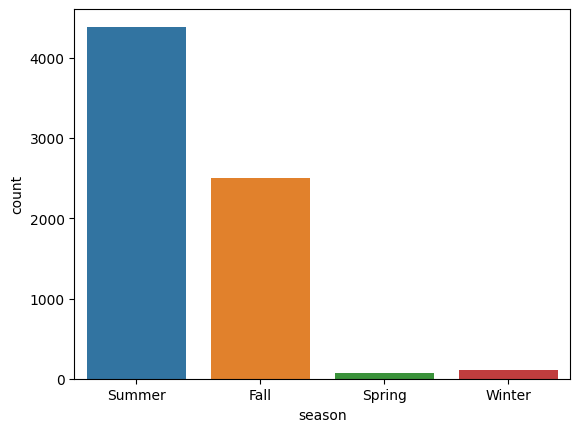

In [55]:
# Plotting the graph for t_shirts
sns.countplot(t_shirts, x='season')

In [56]:
t_shirts.season.mode()[0]

'Summer'

In [57]:
fashion_df.at[21285, 'season'] = t_shirts.season.mode()[0]

In [58]:
fashion_df.iloc[21283]

id                                                                53781
gender                                                              Men
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                           Summer
year                                                                NaN
usage                                                            Sports
productDisplayName               Puma Men Blue Sless Round Neck T-shirt
filename                                                      53781.jpg
link                  http://assets.myntassets.com/assets/images/537...
identity                                                          53781
Name: 21285, dtype: object

In [59]:
fashion_df[fashion_df.id == 53781]

id gender masterCategory subCategory articleType baseColour  season  \
21285  53781    Men        Apparel     Topwear     Tshirts       Blue  Summer   

       year   usage                      productDisplayName   filename  \
21285   NaN  Sports  Puma Men Blue Sless Round Neck T-shirt  53781.jpg   

                                                    link  identity  
21285  http://assets.myntassets.com/assets/images/537...     53781

In [60]:
fashion_df.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour              0
season                  0
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
identity                0
dtype: int64

###### Cleaning the year column

In [61]:
# Searching for the data with missing year value
fashion_df[fashion_df.year.isna()]

id gender masterCategory subCategory articleType baseColour  season  \
21285  53781    Men        Apparel     Topwear     Tshirts       Blue  Summer   

       year   usage                      productDisplayName   filename  \
21285   NaN  Sports  Puma Men Blue Sless Round Neck T-shirt  53781.jpg   

                                                    link  identity  
21285  http://assets.myntassets.com/assets/images/537...     53781

In [62]:
# Getting the mode of the year because year here is used as a category
t_shirts.year.mode()[0]

2011.0

In [63]:
t_shirts.year.value_counts()

year
2011.0    4167
2012.0    2298
2010.0     351
2013.0     101
2016.0      94
2015.0      45
2014.0       4
2009.0       3
2017.0       3
2008.0       1
2018.0       1
Name: count, dtype: int64

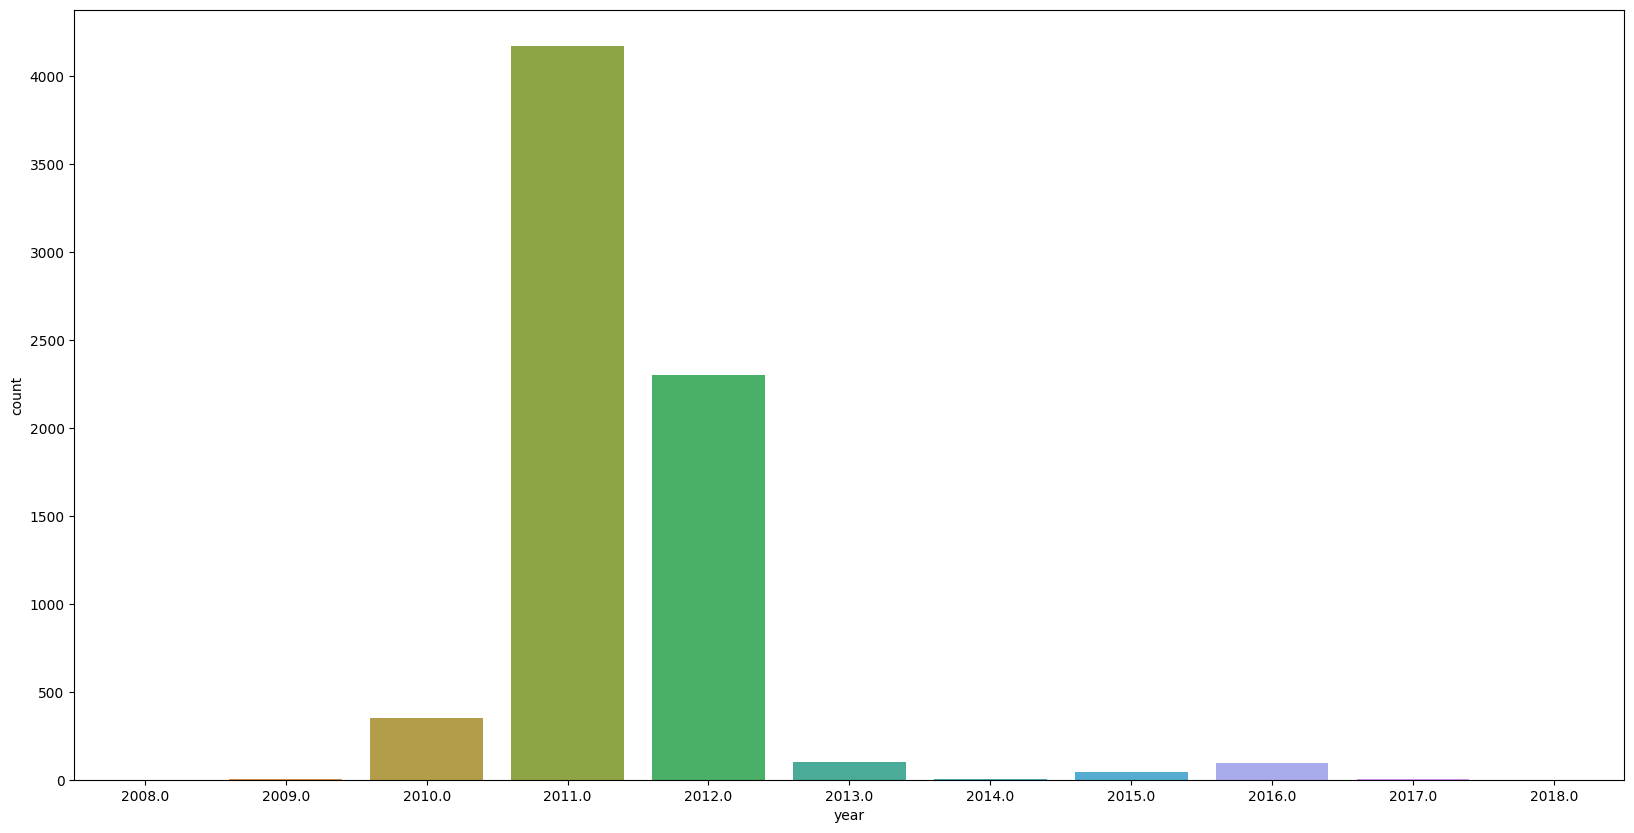

In [64]:
# Plotting the graph for year of t_shirts
plt.figure(figsize=(20,10))
sns.countplot(t_shirts, x='year')
plt.show()

In [65]:
# Assigning the mode of the year to the data with the missing year
fashion_df.at[21285, 'year'] = t_shirts.year.mode()[0]

###### Cleaning the usage column

In [66]:
missing_usage = fashion_df[fashion_df.usage.isna()]
missing_usage

id  gender masterCategory       subCategory            articleType  \
87     56489   Women  Personal Care             Nails            Nail Polish   
92     52029  Unisex        Apparel           Topwear            Rain Jacket   
292    55001   Women  Personal Care              Lips               Lipstick   
479    57563   Women  Personal Care              Lips               Lipstick   
511    55006   Women  Personal Care              Lips              Lip Gloss   
...      ...     ...            ...               ...                    ...   
43655  56605   Women  Personal Care            Makeup     Kajal and Eyeliner   
44101  57715   Women  Personal Care              Lips              Lip Gloss   
44246  43120     Men  Personal Care         Fragrance  Perfume and Body Mist   
44249  55045   Women  Personal Care              Lips               Lipstick   
44365   6839  Unisex    Accessories  Shoe Accessories       Shoe Accessories   

         baseColour  season    year usage  \
87           Bronze  Spring  2017.0   NaN   
92     Coffee Brown  Summer  2012.0   NaN   
292            Pink  Spring  2017.0   NaN   
479           Brown  Spring  2017.0   NaN   
511          Copper  Spring  2017.0   NaN   
...             ...     ...     ...   ...   
43655         Black  Spring  2017.0   NaN   
44101           Red  Spring  2017.0   NaN   
44246          Gold  Spring  2017.0   NaN   
44249        Purple  Spring  2017.0   NaN   
44365         Black  Winter  2015.0   NaN   

                                      productDisplayName   filename  \
87                       Streetwear Ash Nail Polish # 31  56489.jpg   
92              Just Natural Unisex Charcoal Rain Jacket  52029.jpg   
292          Lakme Absolute Lip Last Day Kiss Lip Colour  55001.jpg   
479    Lotus Herbals Pure Colours Nutty Brown Lipstic...  57563.jpg   
511                       Lakme Sheer Satin Lip Gloss 51  55006.jpg   
...                                                  ...        ...   
43655                      Streetwear Black Eye Liner 01  56605.jpg   
44101  Lotus Herbals Seduction Sappy Watermelon Lip G...  57715.jpg   
44246        GUESS by Marciano Men Eau De Toilette 50 ml  43120.jpg   
44249                   Lakme Enrich Satins Lipstick 461  55045.jpg   
44365         Timberland Unisex Waximum Shoe Accessories   6839.jpg   

                                                    link  identity  
87     http://assets.myntassets.com/v1/images/style/p...     56489  
92     http://assets.myntassets.com/v1/images/style/p...     52029  
292    http://assets.myntassets.com/assets/images/550...     55001  
479    http://assets.myntassets.com/assets/images/575...     57563  
511    http://assets.myntassets.com/v1/images/style/p...     55006  
...                                                  ...       ...  
43655  http://assets.myntassets.com/v1/images/style/p...     56605  
44101  http://assets.myntassets.com/v1/images/style/p...     57715  
44246  http://assets.myntassets.com/assets/images/431...     43120  
44249  http://assets.myntassets.com/v1/images/style/p...     55045  
44365  http://assets.myntassets.com/v1/images/style/p...      6839  

[317 rows x 13 columns]

In [67]:
fashion_df.usage.unique()

array(['Casual', 'Ethnic', 'Formal', 'Sports', nan, 'Smart Casual',
       'Travel', 'Party', 'Home'], dtype=object)

In [68]:
missing_usage.masterCategory.unique()

array(['Personal Care', 'Apparel', 'Accessories', 'Footwear'],
      dtype=object)

In [69]:
missing_usage.subCategory.unique()

array(['Nails', 'Topwear', 'Lips', 'Loungewear and Nightwear',
       'Skin Care', 'Skin', 'Makeup', 'Shoe Accessories', 'Bath and Body',
       'Eyes', 'Sandal', 'Wallets', 'Fragrance', 'Innerwear',
       'Bottomwear', 'Beauty Accessories'], dtype=object)

In [70]:
fashion_df[fashion_df.masterCategory == 'Personal Care' ]

id gender masterCategory subCategory             articleType  \
24     18461    Men  Personal Care   Fragrance               Deodorant   
28     56019  Women  Personal Care        Lips                Lipstick   
66     43993  Women  Personal Care   Fragrance   Perfume and Body Mist   
87     56489  Women  Personal Care       Nails             Nail Polish   
99     43967  Women  Personal Care   Fragrance   Perfume and Body Mist   
...      ...    ...            ...         ...                     ...   
44357  32527    Men  Personal Care   Fragrance               Deodorant   
44359  56062  Women  Personal Care        Lips               Lip Gloss   
44418  56634  Women  Personal Care   Skin Care  Face Wash and Cleanser   
44438  55283  Women  Personal Care      Makeup   Highlighter and Blush   
44444  46694  Women  Personal Care   Fragrance   Perfume and Body Mist   

      baseColour  season    year   usage  \
24         White  Spring  2017.0  Casual   
28         Brown  Spring  2017.0  Casual   
66          Pink  Spring  2017.0  Casual   
87        Bronze  Spring  2017.0     NaN   
99           Red  Spring  2017.0  Casual   
...          ...     ...     ...     ...   
44357       Blue  Spring  2017.0  Casual   
44359       Pink  Spring  2017.0  Casual   
44418      Black  Spring  2017.0  Casual   
44438       Pink  Spring  2017.0  Casual   
44444       Blue  Spring  2017.0  Casual   

                                      productDisplayName   filename  \
24                      David Beckham Signature Men Deos  18461.jpg   
28     Colorbar Soft Touch Show Stopper Copper Lipsti...  56019.jpg   
66                          Police Women Passion Perfume  43993.jpg   
87                       Streetwear Ash Nail Polish # 31  56489.jpg   
99                      DKNY Women Red Delicious Perfume  43967.jpg   
...                                                  ...        ...   
44357                   Tonino Lamborghini Men Forza Deo  32527.jpg   
44359        Colorbar Extra Durable Gossip Lip Color 005  56062.jpg   
44418   Olay Women Total Effects 7 in 1 Foaming Cleanser  56634.jpg   
44438  Lakme Absolute Cheek Chromatic Day Blushes Blu...  55283.jpg   
44444                     Rasasi Women Blue Lady Perfume  46694.jpg   

                                                    link  identity  
24     http://assets.myntassets.com/v1/images/style/p...     18461  
28     http://assets.myntassets.com/assets/images/560...     56019  
66     http://assets.myntassets.com/v1/images/style/p...     43993  
87     http://assets.myntassets.com/v1/images/style/p...     56489  
99     http://assets.myntassets.com/v1/images/style/p...     43967  
...                                                  ...       ...  
44357  http://assets.myntassets.com/v1/images/style/p...     32527  
44359  http://assets.myntassets.com/v1/images/style/p...     56062  
44418  http://assets.myntassets.com/v1/images/style/p...     56634  
44438  http://assets.myntassets.com/v1/images/style/p...     55283  
44444  http://assets.myntassets.com/v1/images/style/p...     46694  

[2404 rows x 13 columns]

In [71]:
missing_usage[missing_usage.subCategory == 'Topwear']

id  gender masterCategory subCategory  articleType    baseColour  \
92     52029  Unisex        Apparel     Topwear  Rain Jacket  Coffee Brown   
900    52027  Unisex        Apparel     Topwear  Rain Jacket     Navy Blue   
1184   26367   Women        Apparel     Topwear       Shirts      Lavender   
2119   52045  Unisex        Apparel     Topwear  Rain Jacket         Black   
2587   52042  Unisex        Apparel     Topwear  Rain Jacket         Black   
3467   52026  Unisex        Apparel     Topwear  Rain Jacket          Grey   
3843   52028  Unisex        Apparel     Topwear  Rain Jacket         Brown   
4272   52043  Unisex        Apparel     Topwear  Rain Jacket     Navy Blue   
4639   52044  Unisex        Apparel     Topwear  Rain Jacket         Black   
18569  52032  Unisex        Apparel     Topwear  Rain Jacket           Red   
26994  26365   Women        Apparel     Topwear       Shirts         White   
39118  52031  Unisex        Apparel     Topwear  Rain Jacket         Black   
42404  26370   Women        Apparel     Topwear       Shirts         Black   
42784  52030  Unisex        Apparel     Topwear  Rain Jacket         Olive   

       season    year usage  \
92     Summer  2012.0   NaN   
900    Summer  2012.0   NaN   
1184   Summer  2012.0   NaN   
2119   Summer  2012.0   NaN   
2587   Summer  2012.0   NaN   
3467   Summer  2012.0   NaN   
3843   Summer  2012.0   NaN   
4272   Summer  2012.0   NaN   
4639   Summer  2012.0   NaN   
18569  Summer  2012.0   NaN   
26994  Summer  2012.0   NaN   
39118  Summer  2012.0   NaN   
42404  Summer  2012.0   NaN   
42784  Summer  2012.0   NaN   

                                      productDisplayName   filename  \
92              Just Natural Unisex Charcoal Rain Jacket  52029.jpg   
900            Just Natural Unisex Navy Blue Rain Jacket  52027.jpg   
1184                          Arrow Woman Lavender Shirt  26367.jpg   
2119   Just Natural Unisex Black and Grey Reversible ...  52045.jpg   
2587               Just Natural Unisex Black Rain Jacket  52042.jpg   
3467                Just Natural Unisex Grey Rain Jacket  52026.jpg   
3843               Just Natural Unisex Brown Rain Jacket  52028.jpg   
4272                Just Natural Unisex Navy Blue Jacket  52043.jpg   
4639   Just Natural Unisex Black and Olive Reversible...  52044.jpg   
18569                Just Natural Unisex Red Rain Jacket  52032.jpg   
26994                            Arrow Woman White Shirt  26365.jpg   
39118              Just Natural Unisex Black Rain Jacket  52031.jpg   
42404                    Arrow Woman Striped Black Shirt  26370.jpg   
42784              Just Natural Unisex Olive Rain Jacket  52030.jpg   

                                                    link  identity  
92     http://assets.myntassets.com/v1/images/style/p...     52029  
900    http://assets.myntassets.com/v1/images/style/p...     52027  
1184   http://assets.myntassets.com/v1/images/style/p...     26367  
2119   http://assets.myntassets.com/v1/images/style/p...     52045  
2587   http://assets.myntassets.com/v1/images/style/p...     52042  
3467   http://assets.myntassets.com/v1/images/style/p...     52026  
3843   http://assets.myntassets.com/v1/images/style/p...     52028  
4272   http://assets.myntassets.com/v1/images/style/p...     52043  
4639   http://assets.myntassets.com/v1/images/style/p...     52044  
18569  http://assets.myntassets.com/v1/images/style/p...     52032  
26994  http://assets.myntassets.com/v1/images/style/p...     26365  
39118  http://assets.myntassets.com/v1/images/style/p...     52031  
42404  http://assets.myntassets.com/v1/images/style/p...     26370  
42784  http://assets.myntassets.com/v1/images/style/p...     52030

After going through the data with missing usage, I realized that the categories which i want to deal with are which are men's sneakers and tshirts, are not involved here. Therefore I did not bother to clean the usage category

###### Cleaning the productDisplayName column

In [72]:
missing_productDisplayName = fashion_df[fashion_df.productDisplayName.isna()]
missing_productDisplayName

id gender masterCategory subCategory            articleType  \
3677   42878  Women    Accessories        Bags               Clutches   
14302  30991  Women  Personal Care   Fragrance  Perfume and Body Mist   
17652  45687    Men  Personal Care   Fragrance  Perfume and Body Mist   
22102  42863  Women    Accessories        Bags               Clutches   
23497  45698  Women  Personal Care   Fragrance  Perfume and Body Mist   
37549  30992    Men  Personal Care   Fragrance  Perfume and Body Mist   
40697  43119    Men  Personal Care   Fragrance  Perfume and Body Mist   

      baseColour  season    year   usage productDisplayName   filename  \
3677      Maroon  Summer  2012.0  Casual                NaN  42878.jpg   
14302      Cream  Spring  2017.0     NaN                NaN  30991.jpg   
17652       Blue  Spring  2017.0     NaN                NaN  45687.jpg   
22102      Brown  Summer  2012.0  Casual                NaN  42863.jpg   
23497      Beige  Spring  2017.0     NaN                NaN  45698.jpg   
37549  off white  Spring  2017.0     NaN                NaN  30992.jpg   
40697       Gold  Spring  2017.0     NaN                NaN  43119.jpg   

                                                    link  identity  
3677   http://assets.myntassets.com/v1/images/style/p...     42878  
14302  http://assets.myntassets.com/assets/images/309...     30991  
17652  http://assets.myntassets.com/assets/images/456...     45687  
22102  http://assets.myntassets.com/v1/images/style/p...     42863  
23497  http://assets.myntassets.com/assets/images/456...     45698  
37549  http://assets.myntassets.com/assets/images/309...     30992  
40697  http://assets.myntassets.com/assets/images/431...     43119

Once again, I realized that the data with missing product names had nothing to do with the images I need (Men's sneakers and tshirts). Therefore, there was no need for me to clean the product display name. 

### Creating a dataframe for all the items I need which are Men's Sneakers 

In [73]:
fashion_df.masterCategory.unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care',
       'Free Items', 'Sporting Goods', 'Home'], dtype=object)

In [74]:
fashion_df.gender.unique()

array(['Men', 'Women', 'Boys', 'Girls', 'Unisex'], dtype=object)

In [75]:
fashion_df.subCategory.unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts',
       'Flip Flops', 'Bags', 'Innerwear', 'Sandal', 'Shoe Accessories',
       'Fragrance', 'Jewellery', 'Lips', 'Saree', 'Eyewear', 'Nails',
       'Scarves', 'Dress', 'Loungewear and Nightwear', 'Wallets',
       'Apparel Set', 'Headwear', 'Mufflers', 'Skin Care', 'Makeup',
       'Free Gifts', 'Ties', 'Accessories', 'Skin', 'Beauty Accessories',
       'Water Bottle', 'Eyes', 'Bath and Body', 'Gloves',
       'Sports Accessories', 'Cufflinks', 'Sports Equipment', 'Stoles',
       'Hair', 'Perfumes', 'Home Furnishing', 'Umbrellas', 'Wristbands',
       'Vouchers'], dtype=object)

In [76]:
sport_goods = fashion_df[fashion_df.masterCategory == 'Sporting Goods']
sport_goods

id  gender  masterCategory       subCategory  articleType  \
5052   13670  Unisex  Sporting Goods  Sports Equipment    Footballs   
6065    2355  Unisex  Sporting Goods  Sports Equipment    Footballs   
9253    2354  Unisex  Sporting Goods  Sports Equipment  Basketballs   
11373   4010  Unisex  Sporting Goods  Sports Equipment  Basketballs   
11924   1553  Unisex  Sporting Goods  Sports Equipment    Footballs   
14518   1552  Unisex  Sporting Goods  Sports Equipment    Footballs   
14656   8422  Unisex  Sporting Goods  Sports Equipment  Basketballs   
15094   4011  Unisex  Sporting Goods  Sports Equipment  Basketballs   
19922  42830  Unisex  Sporting Goods        Wristbands   Wristbands   
22949  42829  Unisex  Sporting Goods        Wristbands   Wristbands   
25484  42828  Unisex  Sporting Goods        Wristbands   Wristbands   
28078   4008  Unisex  Sporting Goods  Sports Equipment  Basketballs   
29288   2356  Unisex  Sporting Goods  Sports Equipment  Basketballs   
31054   4007  Unisex  Sporting Goods  Sports Equipment  Basketballs   
31874   4009  Unisex  Sporting Goods  Sports Equipment  Basketballs   
35089   8427  Unisex  Sporting Goods  Sports Equipment  Basketballs   
35351   4013  Unisex  Sporting Goods  Sports Equipment  Basketballs   
35948   1550  Unisex  Sporting Goods  Sports Equipment    Footballs   
37759   1551  Unisex  Sporting Goods  Sports Equipment    Footballs   
38324   8426  Unisex  Sporting Goods  Sports Equipment  Basketballs   
38417   4012  Unisex  Sporting Goods  Sports Equipment  Basketballs   
38966   1627  Unisex  Sporting Goods  Sports Equipment    Footballs   
39064   8934  Unisex  Sporting Goods        Wristbands   Wristbands   
42274   1628  Unisex  Sporting Goods  Sports Equipment  Basketballs   
42823   1626  Unisex  Sporting Goods  Sports Equipment    Footballs   

      baseColour  season    year   usage  \
5052        Gold    Fall  2011.0  Casual   
6065       White    Fall  2010.0  Sports   
9253       Black  Winter  2010.0  Sports   
11373      Brown  Summer  2011.0  Sports   
11924      White    Fall  2010.0  Sports   
14518      White    Fall  2010.0  Sports   
14656        Red    Fall  2011.0  Sports   
15094       Grey  Summer  2011.0  Sports   
19922      Black  Summer  2012.0  Sports   
22949      White  Summer  2012.0  Sports   
25484        Red  Summer  2012.0  Sports   
28078     Yellow  Summer  2011.0  Sports   
29288      Black  Winter  2010.0  Sports   
31054     Orange  Summer  2011.0  Sports   
31874       Blue  Summer  2011.0  Casual   
35089       Blue    Fall  2011.0  Sports   
35351      Brown  Summer  2011.0  Casual   
35948      White    Fall  2010.0  Sports   
37759     Orange    Fall  2010.0  Sports   
38324        Red    Fall  2011.0  Sports   
38417      Black  Summer  2011.0  Sports   
38966      White    Fall  2010.0  Sports   
39064      Black    Fall  2011.0  Casual   
42274      Brown  Summer  2011.0  Sports   
42823       Blue  Summer  2011.0  Sports   

                                      productDisplayName   filename  \
5052                        Puma Unisex Liga XL Football  13670.jpg   
6065       ADIDAS Red Bull Trophy Soccer Unisex Football   2355.jpg   
9253               ADIDAS Black Bounce Unisex Basketball   2354.jpg   
11373                   Spalding 150 SZ Brown Basketball   4010.jpg   
11924                Puma Power Cat Hard Ground Football   1553.jpg   
14518                 Puma Power Cat Trainer-WR Football   1552.jpg   
14656      Spalding Unisex NBA Highlight Red Basketballs   8422.jpg   
15094                     Spalding Buror Grey Basketball   4011.jpg   
19922                Nike Unisex Swoosh Black Wristbands  42830.jpg   
22949                Nike Unisex Swoosh White Wristbands  42829.jpg   
25484                  Nike Unisex Swoosh Red Wristbands  42828.jpg   
28078            Spalding Unisex Ochre Yellow Basketball   4008.jpg   
29288             ADIDAS Black & White Unisex Basketball   2356.jpg   
31054             Spaldi

In [77]:
just_men = fashion_df[fashion_df['gender'].isin(['Men', 'Boys', 'Unisex'])]
just_men

id gender masterCategory subCategory   articleType baseColour  \
0      15970    Men        Apparel     Topwear        Shirts  Navy Blue   
1      39386    Men        Apparel  Bottomwear         Jeans       Blue   
3      21379    Men        Apparel  Bottomwear   Track Pants      Black   
4      53759    Men        Apparel     Topwear       Tshirts       Grey   
5       1855    Men        Apparel     Topwear       Tshirts       Grey   
...      ...    ...            ...         ...           ...        ...   
44436  30614    Men        Apparel     Topwear       Tshirts      Black   
44437  13496    Men        Apparel     Topwear       Tshirts       Blue   
44441  17036    Men       Footwear       Shoes  Casual Shoes      White   
44442   6461    Men       Footwear  Flip Flops    Flip Flops        Red   
44443  18842    Men        Apparel     Topwear       Tshirts       Blue   

       season    year   usage                             productDisplayName  \
0        Fall  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1      Summer  2012.0  Casual             Peter England Men Party Blue Jeans   
3        Fall  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4      Summer  2012.0  Casual                          Puma Men Grey T-shirt   
5      Summer  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt   
...       ...     ...     ...                                            ...   
44436  Summer  2012.0  Sports                  Nike Men Striped Black Jersey   
44437    Fall  2011.0  Casual          Chimp Men Teja Main Hoon Blue Tshirts   
44441  Summer  2013.0  Casual                      Gas Men Caddy Casual Shoe   
44442  Summer  2011.0  Casual             Lotto Men's Soccer Track Flip Flop   
44443    Fall  2011.0  Casual           Puma Men Graphic Stellar Blue Tshirt   

        filename                                               link  identity  
0      15970.jpg  http://assets.myntassets.com/v1/images/style/p...     15970  
1      39386.jpg  http://assets.myntassets.com/v1/images/style/p...     39386  
3      21379.jpg  http://assets.myntassets.com/v1/images/style/p...     21379  
4      53759.jpg  http://assets.myntassets.com/v1/images/style/p...     53759  
5       1855.jpg  http://assets.myntassets.com/v1/images/style/p...      1855  
...          ...                                                ...       ...  
44436  30614.jpg  http://assets.myntassets.com/v1/images/style/p...     30614  
44437  13496.jpg  http://assets.myntassets.com/v1/images/style/p...     13496  
44441  17036.jpg  http://assets.myntassets.com/v1/images/style/p...     17036  
44442   6461.jpg  http://assets.myntassets.com/v1/images/style/p...      6461  
44443  18842.jpg  http://assets.myntassets.com/v1/images/style/p...     18842  

[25154 rows x 13 columns]

In [78]:
just_men.gender.unique()

array(['Men', 'Boys', 'Unisex'], dtype=object)

In [79]:
just_men.masterCategory.unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care',
       'Free Items', 'Sporting Goods', 'Home'], dtype=object)

In [80]:
men_footwear = just_men[just_men['masterCategory'] == 'Footwear']
men_footwear

id gender masterCategory subCategory   articleType baseColour  \
10      9204    Men       Footwear       Shoes  Casual Shoes      Black   
12     18653    Men       Footwear  Flip Flops    Flip Flops      Black   
14     46885   Boys       Footwear  Flip Flops    Flip Flops  Navy Blue   
21     12967    Men       Footwear      Sandal       Sandals      Black   
25      9036    Men       Footwear       Shoes  Formal Shoes      Black   
...      ...    ...            ...         ...           ...        ...   
44413   4104    Men       Footwear      Sandal       Sandals      Black   
44415  14481    Men       Footwear       Shoes  Casual Shoes      Beige   
44426   4336    Men       Footwear       Shoes  Sports Shoes      White   
44441  17036    Men       Footwear       Shoes  Casual Shoes      White   
44442   6461    Men       Footwear  Flip Flops    Flip Flops        Red   

       season    year   usage  \
10     Summer  2011.0  Casual   
12       Fall  2011.0  Casual   
14       Fall  2012.0  Casual   
21       Fall  2011.0  Casual   
25     Winter  2011.0  Formal   
...       ...     ...     ...   
44413  Summer  2011.0  Casual   
44415    Fall  2011.0  Casual   
44426  Summer  2011.0  Sports   
44441  Summer  2013.0  Casual   
44442  Summer  2011.0  Casual   

                                    productDisplayName   filename  \
10     Puma Men Future Cat Remix SF Black Casual Shoes   9204.jpg   
12                   Fila Men Cush Flex Black Slippers  18653.jpg   
14                      Ben 10 Boys Navy Blue Slippers  46885.jpg   
21                     ADIDAS Men Spry M Black Sandals  12967.jpg   
25              Buckaroo Men Flores Black Formal Shoes   9036.jpg   
...                                                ...        ...   
44413                     Fila Men Tremor Black Sandal   4104.jpg   
44415            Flying Machine Men Beige Casual Shoes  14481.jpg   
44426              Fila Men's Leonard White Black Shoe   4336.jpg   
44441                        Gas Men Caddy Casual Shoe  17036.jpg   
44442               Lotto Men's Soccer Track Flip Flop   6461.jpg   

                                                    link  identity  
10     http://assets.myntassets.com/v1/images/style/p...      9204  
12     http://assets.myntassets.com/v1/images/style/p...     18653  
14     http://assets.myntassets.com/v1/images/style/p...     46885  
21     http://assets.myntassets.com/v1/images/style/p...     12967  
25     http://assets.myntassets.com/v1/images/style/p...      9036  
...                                                  ...       ...  
44413  http://assets.myntassets.com/v1/images/style/p...      4104  
44415  http://assets.myntassets.com/v1/images/style/p...     14481  
44426  http://assets.myntassets.com/v1/images/style/p...      4336  
44441  http://assets.myntassets.com/v1/images/style/p...     17036  
44442  http://assets.myntassets.com/v1/images/style/p...      6461  

[6326 rows x 13 columns]

In [81]:
men_footwear.subCategory.unique()

array(['Shoes', 'Flip Flops', 'Sandal'], dtype=object)

In [82]:
men_shoes = men_footwear[men_footwear['subCategory'] == 'Shoes']
men_shoes

id  gender masterCategory subCategory   articleType baseColour  \
10      9204     Men       Footwear       Shoes  Casual Shoes      Black   
25      9036     Men       Footwear       Shoes  Formal Shoes      Black   
33     39988     Men       Footwear       Shoes  Casual Shoes      White   
45      3168     Men       Footwear       Shoes  Sports Shoes      White   
51     10268     Men       Footwear       Shoes  Formal Shoes      Black   
...      ...     ...            ...         ...           ...        ...   
44396  24670  Unisex       Footwear       Shoes  Casual Shoes      White   
44407   6653     Men       Footwear       Shoes  Casual Shoes      White   
44415  14481     Men       Footwear       Shoes  Casual Shoes      Beige   
44426   4336     Men       Footwear       Shoes  Sports Shoes      White   
44441  17036     Men       Footwear       Shoes  Casual Shoes      White   

       season    year   usage  \
10     Summer  2011.0  Casual   
25     Winter  2011.0  Formal   
33     Winter  2014.0  Casual   
45       Fall  2010.0  Sports   
51       Fall  2012.0  Formal   
...       ...     ...     ...   
44396    Fall  2010.0  Casual   
44407  Summer  2011.0  Casual   
44415    Fall  2011.0  Casual   
44426  Summer  2011.0  Sports   
44441  Summer  2013.0  Casual   

                                    productDisplayName   filename  \
10     Puma Men Future Cat Remix SF Black Casual Shoes   9204.jpg   
25              Buckaroo Men Flores Black Formal Shoes   9036.jpg   
33                          Gas Men Europa White Shoes  39988.jpg   
45           Nike Men's Incinerate MSL White Blue Shoe   3168.jpg   
51     Clarks Men Hang Work Leather Black Formal Shoes  10268.jpg   
...                                                ...        ...   
44396        Converse Unisex Floral Print Casual Shoes  24670.jpg   
44407           Nike Men's Air Force White Orange Shoe   6653.jpg   
44415            Flying Machine Men Beige Casual Shoes  14481.jpg   
44426              Fila Men's Leonard White Black Shoe   4336.jpg   
44441                        Gas Men Caddy Casual Shoe  17036.jpg   

                                                    link  identity  
10     http://assets.myntassets.com/v1/images/style/p...      9204  
25     http://assets.myntassets.com/v1/images/style/p...      9036  
33     http://assets.myntassets.com/v1/images/style/p...     39988  
45     http://assets.myntassets.com/v1/images/style/p...      3168  
51     http://assets.myntassets.com/v1/images/style/p...     10268  
...                                                  ...       ...  
44396  http://assets.myntassets.com/v1/images/style/p...     24670  
44407  http://assets.myntassets.com/v1/images/style/p...      6653  
44415  http://assets.myntassets.com/v1/images/style/p...     14481  
44426  http://assets.myntassets.com/v1/images/style/p...      4336  
44441  http://assets.myntassets.com/v1/images/style/p...     17036  

[4775 rows x 13 columns]

In [83]:
men_shoes.articleType.unique()

array(['Casual Shoes', 'Formal Shoes', 'Sports Shoes', 'Sandals', 'Heels'],
      dtype=object)

In [84]:
men_sneakers = men_shoes[men_shoes['articleType'].isin(['Casual Shoes', 'Sports Shoes'])]
men_sneakers

id  gender masterCategory subCategory   articleType baseColour  \
10      9204     Men       Footwear       Shoes  Casual Shoes      Black   
33     39988     Men       Footwear       Shoes  Casual Shoes      White   
45      3168     Men       Footwear       Shoes  Sports Shoes      White   
64     22198     Men       Footwear       Shoes  Casual Shoes      Black   
65     29570     Men       Footwear       Shoes  Casual Shoes     Purple   
...      ...     ...            ...         ...           ...        ...   
44396  24670  Unisex       Footwear       Shoes  Casual Shoes      White   
44407   6653     Men       Footwear       Shoes  Casual Shoes      White   
44415  14481     Men       Footwear       Shoes  Casual Shoes      Beige   
44426   4336     Men       Footwear       Shoes  Sports Shoes      White   
44441  17036     Men       Footwear       Shoes  Casual Shoes      White   

       season    year   usage  \
10     Summer  2011.0  Casual   
33     Winter  2014.0  Casual   
45       Fall  2010.0  Sports   
64       Fall  2012.0  Casual   
65     Summer  2012.0  Casual   
...       ...     ...     ...   
44396    Fall  2010.0  Casual   
44407  Summer  2011.0  Casual   
44415    Fall  2011.0  Casual   
44426  Summer  2011.0  Sports   
44441  Summer  2013.0  Casual   

                                    productDisplayName   filename  \
10     Puma Men Future Cat Remix SF Black Casual Shoes   9204.jpg   
33                          Gas Men Europa White Shoes  39988.jpg   
45           Nike Men's Incinerate MSL White Blue Shoe   3168.jpg   
64                   Timberland Men Black Casual Shoes  22198.jpg   
65       Vans Men Classic Slip-On Purple & Black Shoes  29570.jpg   
...                                                ...        ...   
44396        Converse Unisex Floral Print Casual Shoes  24670.jpg   
44407           Nike Men's Air Force White Orange Shoe   6653.jpg   
44415            Flying Machine Men Beige Casual Shoes  14481.jpg   
44426              Fila Men's Leonard White Black Shoe   4336.jpg   
44441                        Gas Men Caddy Casual Shoe  17036.jpg   

                                                    link  identity  
10     http://assets.myntassets.com/v1/images/style/p...      9204  
33     http://assets.myntassets.com/v1/images/style/p...     39988  
45     http://assets.myntassets.com/v1/images/style/p...      3168  
64     http://assets.myntassets.com/v1/images/style/p...     22198  
65     http://assets.myntassets.com/v1/images/style/p...     29570  
...                                                  ...       ...  
44396  http://assets.myntassets.com/v1/images/style/p...     24670  
44407  http://assets.myntassets.com/v1/images/style/p...      6653  
44415  http://assets.myntassets.com/v1/images/style/p...     14481  
44426  http://assets.myntassets.com/v1/images/style/p...      4336  
44441  http://assets.myntassets.com/v1/images/style/p...     17036  

[4135 rows x 13 columns]

###### Resizing and saving images into a new folder

In [85]:
filenames = []
for filename in men_sneakers['filename']:
    filenames.append(filename)

In [86]:
# resized_path = r'D:/fashion-dataset/images/resized_sneakers/'
resized_path = r'D:/fashion-dataset/images/resized_sneakers_2/'

In [87]:
if not os.path.isdir(resized_path):
    os.makedirs(resized_path)
    
for filename in filenames:
    im = Image.open(IMG_PATH +'/'+ filename)
    resized_image = im.resize((128,128))
    resized_image.save(resized_path + filename)

In [88]:
# # Storing all the names of the images in the fashion-dataset folder into an array
# resized_sneakers_list = os.listdir('resized_sneakers/')
# resized_sneakers_list

# Storing all the names of the images in the fashion-dataset folder into an array
resized_sneakers_list = os.listdir(r'D:/fashion-dataset/images/resized_sneakers_2/')
resized_sneakers_list

['10035.jpg',
 '10037.jpg',
 '10039.jpg',
 '10078.jpg',
 '10080.jpg',
 '10081.jpg',
 '10088.jpg',
 '10092.jpg',
 '10093.jpg',
 '10095.jpg',
 '10097.jpg',
 '10101.jpg',
 '10102.jpg',
 '10104.jpg',
 '10111.jpg',
 '10113.jpg',
 '10117.jpg',
 '10122.jpg',
 '10126.jpg',
 '10127.jpg',
 '10142.jpg',
 '10144.jpg',
 '10148.jpg',
 '10152.jpg',
 '10154.jpg',
 '10155.jpg',
 '10156.jpg',
 '10158.jpg',
 '10159.jpg',
 '10160.jpg',
 '10161.jpg',
 '10162.jpg',
 '10167.jpg',
 '10168.jpg',
 '10169.jpg',
 '10170.jpg',
 '10172.jpg',
 '10174.jpg',
 '10175.jpg',
 '10176.jpg',
 '10177.jpg',
 '10178.jpg',
 '10266.jpg',
 '10267.jpg',
 '10278.jpg',
 '10279.jpg',
 '10295.jpg',
 '10296.jpg',
 '10297.jpg',
 '10301.jpg',
 '10305.jpg',
 '10306.jpg',
 '10308.jpg',
 '10517.jpg',
 '10533.jpg',
 '10626.jpg',
 '10627.jpg',
 '10628.jpg',
 '10629.jpg',
 '10630.jpg',
 '10631.jpg',
 '10632.jpg',
 '10635.jpg',
 '10636.jpg',
 '10639.jpg',
 '10640.jpg',
 '10772.jpg',
 '10783.jpg',
 '11815.jpg',
 '11816.jpg',
 '11817.jpg',
 '1181

In [89]:
len(resized_sneakers_list)

4135

In [90]:
# Looping through to search for missing resized images
missing_resized_images = []
for i in men_sneakers['filename']:
    if i not in resized_sneakers_list:
        missing_resized_images.append(i)
        
print(missing_resized_images)

[]


In [91]:
len(missing_resized_images)

0

In [92]:
# # manually assigning the image filenames because I manually deleted the images
# removed_resized_images = ['22198.jpg', '26538.jpg', '39943.jpg', '50741.jpg', '19329.jpg', '39944.jpg', '12507.jpg', '39972.jpg', '16165.jpg', '22162.jpg', '47501.jpg', '22196.jpg', '13087.jpg', '12509.jpg', '50748.jpg', '28652.jpg', '32555.jpg', '22191.jpg', '11949.jpg', '22165.jpg', '22733.jpg', '39975.jpg', '37241.jpg', '17813.jpg', '5699.jpg', '47109.jpg', '39310.jpg', '26562.jpg', '37246.jpg', '2817.jpg', '2219.jpg', '18404.jpg', '17814.jpg', '50376.jpg', '5697.jpg', '4577.jpg', '53735.jpg', '9091.jpg', '30258.jpg', '47100.jpg', '5690.jpg', '57530.jpg', '6816.jpg', '37248.jpg', '39742.jpg', '50749.jpg', '12508.jpg', '4183.jpg', '11948.jpg', '22164.jpg', '22732.jpg', '39974.jpg', '22190.jpg', '26537.jpg', '22197.jpg', '10267.jpg', '13086.jpg', '39973.jpg', '7365.jpg', '4184.jpg', '22163.jpg', '9202.jpg', '46883.jpg', '9030.jpg', '12995.jpg', '28662.jpg', '10635.jpg', '12506.jpg', '50747.jpg', '39945.jpg', '46884.jpg', '26539.jpg', '22199.jpg', '39942.jpg', '10632.jpg', '57531.jpg', '37249.jpg', '53734.jpg', '5696.jpg', '56410.jpg', '34090.jpg', '13646.jpg', '50377.jpg', '6448.jpg', '30259.jpg', '6810.jpg', '9090.jpg', '57509.jpg', '26563.jpg', '37247.jpg', '18405.jpg', '28600.jpg', '30257.jpg', '4578.jpg', '5698.jpg', '2399.jpg', '22841.jpg', '57481.jpg', '35465.jpg', '44406.jpg', '21091.jpg', '20715.jpg', '5345.jpg', '13537.jpg', '28316.jpg', '13359.jpg', '22846.jpg', '4069.jpg', '12429.jpg', '5389.jpg', '15866.jpg', '39290.jpg', '35462.jpg', '59178.jpg', '22870.jpg', '39252.jpg', '35659.jpg', '36225.jpg', '44437.jpg', '43878.jpg', '2397.jpg', '55783.jpg', '57488.jpg', '59176.jpg', '22877.jpg', '55784.jpg', '2390.jpg', '12427.jpg', '36480.jpg', '22848.jpg', '28318.jpg', '36222.jpg', '13357.jpg', '17757.jpg', '1541.jpg', '43473.jpg', '17768.jpg', '47488.jpg', '22823.jpg', '13136.jpg', '43474.jpg', '47682.jpg', '40453.jpg', '43480.jpg', '5582.jpg', '22824.jpg', '47649.jpg', '17766.jpg', '10127.jpg', '3218.jpg', '38772.jpg', '17759.jpg', '4495.jpg', '37957.jpg', '38775.jpg', '22815.jpg', '38781.jpg', '58200.jpg', '13369.jpg', '39254.jpg', '22876.jpg', '57489.jpg', '59177.jpg', '5372.jpg', '22849.jpg', '7041.jpg', '35660.jpg', '55785.jpg', '12426.jpg', '4066.jpg', '59342.jpg', '35658.jpg', '13538.jpg', '22871.jpg', '39253.jpg', '10144.jpg', '2396.jpg', '44436.jpg', '36224.jpg', '43879.jpg', '12428.jpg', '4068.jpg', '39291.jpg', '15867.jpg', '12870.jpg', '9121.jpg', '22847.jpg', '21063.jpg', '35463.jpg', '57487.jpg', '22878.jpg', '20713.jpg', '24181.jpg', '22840.jpg', '25857.jpg', '15860.jpg', '2398.jpg', '34542.jpg', '24186.jpg', '5344.jpg', '20714.jpg', '57480.jpg', '31692.jpg', '35464.jpg', '35656.jpg', '4494.jpg', '38780.jpg', '34529.jpg', '13139.jpg', '37956.jpg', '38774.jpg', '17767.jpg', '35053.jpg', '17758.jpg', '35401.jpg', '43475.jpg', '22825.jpg', '13130.jpg', '17756.jpg', '40455.jpg', '22822.jpg', '17769.jpg', '40448.jpg', '41551.jpg', '50423.jpg', '56720.jpg', '22838.jpg', '49509.jpg', '13115.jpg', '4487.jpg', '37973.jpg', '22831.jpg', '44482.jpg', '49369.jpg', '22836.jpg', '37974.jpg', '8082.jpg', '13540.jpg', '35412.jpg', '2371.jpg', '5366.jpg', '5702.jpg', '34752.jpg', '35680.jpg', '13170.jpg', '47092.jpg', '7267.jpg', '35674.jpg', '10533.jpg', '2385.jpg', '5392.jpg', '8210.jpg', '5359.jpg', '20709.jpg', '22862.jpg', '21079.jpg', '35673.jpg', '39278.jpg', '44610.jpg', '44422.jpg', '5361.jpg', '2376.jpg', '22865.jpg', '39247.jpg', '57493.jpg', '5357.jpg', '20707.jpg', '44414.jpg', '12864.jpg', '22853.jpg', '5368.jpg', '44413.jpg', '39249.jpg', '7251.jpg', '13374.jpg', '20700.jpg', '4282.jpg', '28599.jpg', '57494.jpg', '22854.jpg', '39276.jpg', '35219.jpg', '37975.jpg', '4488.jpg', '44817.jpg', '22837.jpg', '6126.jpg', '22830.jpg', '10308.jpg', '47492.jpg', '1590.jpg', '4486.jpg', '14331.jpg', '10301.jpg', '44821.jpg', '56721.jpg', '3462.jpg', '45594.jpg', '50422.jpg', '57495.jpg', '28598.jpg', '39248.jpg', '44412.jpg', '22855.jpg', '12896.jpg', '15881.jpg', '39277.jpg', '20706.jpg', '7401.jpg', '5356.jpg', '44415.jpg', '13372.jpg', '4270.jpg', '57492.jpg', '39270.jpg', '15886.jpg', '5369.jpg', '22852.jpg', '15872.jpg', '5704.jpg', '7261.jpg', '2383.jpg', '5394.jpg', '7408.jpg', '22864.jpg', '4625.jpg', '5393.jpg', '10156.jpg', '5367.jpg', '5703.jpg', '35681.jpg', '10169.jpg', '22863.jpg', '5358.jpg', '2833.jpg', '55629.jpg', '57942.jpg', '6803.jpg', '55616.jpg', '3586.jpg', '57525.jpg', '6490.jpg', '6656.jpg', '5685.jpg', '20689.jpg', '32728.jpg', '6804.jpg', '50738.jpg', '44936.jpg', '5682.jpg', '34084.jpg', '19368.jpg', '57522.jpg', '6497.jpg', '17696.jpg', '34079.jpg', '39302.jpg', '55618.jpg', '20680.jpg', '8997.jpg', '4554.jpg', '47124.jpg', '55627.jpg', '24482.jpg', '20674.jpg', '57514.jpg', '5678.jpg', '39305.jpg', '44938.jpg', '57513.jpg', '20441.jpg', '55620.jpg', '47123.jpg', '20687.jpg', '47183.jpg', '4735.jpg', '45620.jpg', '6634.jpg', '22184.jpg', '39735.jpg', '17056.jpg', '26523.jpg', '22183.jpg', '15365.jpg', '47184.jpg', '39967.jpg', '22177.jpg', '45618.jpg', '15353.jpg', '50753.jpg', '44737.jpg', '16179.jpg', '31551.jpg', '50754.jpg', '56665.jpg', '12515.jpg', '10626.jpg', '22179.jpg', '11955.jpg', '49480.jpg', '39304.jpg', '5679.jpg', '19367.jpg', '2497.jpg', '32727.jpg', '47122.jpg', '20686.jpg', '42034.jpg', '50737.jpg', '41477.jpg', '57512.jpg', '20818.jpg', '34078.jpg', '39303.jpg', '55626.jpg', '20675.jpg', '20681.jpg', '47125.jpg', '9085.jpg', '44937.jpg', '20688.jpg', '6805.jpg', '32729.jpg', '57523.jpg', '19369.jpg', '39904.jpg', '5677.jpg', '5683.jpg', '6462.jpg', '26540.jpg', '34085.jpg', '6802.jpg', '55628.jpg', '57943.jpg', '34082.jpg', '5684.jpg', '3587.jpg', '55617.jpg', '57524.jpg', '6491.jpg', '56664.jpg', '10627.jpg', '15355.jpg', '49481.jpg', '22178.jpg', '49475.jpg', '11954.jpg', '39968.jpg', '15352.jpg', '56663.jpg', '12513.jpg', '7379.jpg', '20842.jpg', '11953.jpg', '29563.jpg', '49486.jpg', '9025.jpg', '39966.jpg', '47185.jpg', '22182.jpg', '26522.jpg', '17057.jpg', '4733.jpg', '7384.jpg', '45619.jpg', '4734.jpg', '12522.jpg', '12710.jpg', '7377.jpg', '47182.jpg', '31330.jpg', '41844.jpg', '2641.jpg', '17484.jpg', '50727.jpg', '19348.jpg', '26561.jpg', '20696.jpg', '37245.jpg', '30252.jpg', '24467.jpg', '30255.jpg', '3552.jpg', '37242.jpg', '32730.jpg', '20691.jpg', '21571.jpg', '17483.jpg', '26559.jpg', '30263.jpg', '5693.jpg', '6486.jpg', '6815.jpg', '20698.jpg', '34862.jpg', '39741.jpg', '24690.jpg', '50375.jpg', '30264.jpg', '5694.jpg', '14495.jpg', '2822.jpg', '17821.jpg', '12997.jpg', '31329.jpg', '39978.jpg', '22168.jpg', '32558.jpg', '22157.jpg', '39947.jpg', '35570.jpg', '15513.jpg', '9035.jpg', '15719.jpg', '16168.jpg', '7369.jpg', '15514.jpg', '45600.jpg', '39940.jpg', '50742.jpg', '16157.jpg', '21728.jpg', '5408.jpg', '22159.jpg', '32556.jpg', '22192.jpg', '10296.jpg', '22166.jpg', '22730.jpg', '39976.jpg', '39971.jpg', '7367.jpg', '22161.jpg', '22195.jpg', '5292.jpg', '15717.jpg', '7393.jpg', '6474.jpg', '24691.jpg', '6813.jpg', '13642.jpg', '17818.jpg', '30262.jpg', '34863.jpg', '6814.jpg', '20699.jpg', '37243.jpg', '3553.jpg', '20690.jpg', '26558.jpg', '24459.jpg', '26560.jpg', '20697.jpg', '30253.jpg', '37244.jpg', '18406.jpg', '49062.jpg', '28657.jpg', '22194.jpg', '13085.jpg', '54742.jpg', '7366.jpg', '22736.jpg', '22160.jpg', '5409.jpg', '22158.jpg', '22167.jpg', '10297.jpg', '12998.jpg', '22731.jpg', '39977.jpg', '39983.jpg', '32557.jpg', '22193.jpg', '9034.jpg', '50743.jpg', '15515.jpg', '10631.jpg', '4526.jpg', '22169.jpg', '35571.jpg', '10636.jpg', '17413.jpg', '57939.jpg', '39946.jpg', '43477.jpg', '47681.jpg', '22818.jpg', '40450.jpg', '24743.jpg', '22827.jpg', '40457.jpg', '13132.jpg', '3488.jpg', '22820.jpg', '47644.jpg', '45583.jpg', '22829.jpg', '23930.jpg', '38776.jpg', '22816.jpg', '43479.jpg', '24775.jpg', '10772.jpg', '47643.jpg', '38785.jpg', '38771.jpg', '40459.jpg', '29267.jpg', '39267.jpg', '28315.jpg', '35698.jpg', '22845.jpg', '2369.jpg', '15865.jpg', '20711.jpg', '24183.jpg', '57471.jpg', '13365.jpg', '10170.jpg', '4267.jpg', '35237.jpg', '24719.jpg', '10148.jpg', '22842.jpg', '12881.jpg', '39260.jpg', '57482.jpg', '35466.jpg', '34540.jpg', '44405.jpg', '5346.jpg', '57476.jpg', '20716.jpg', '4269.jpg', '22874.jpg', '2393.jpg', '36221.jpg', '39269.jpg', '44433.jpg', '5348.jpg', '22873.jpg', '7249.jpg', '39251.jpg', '35691.jpg', '34743.jpg', '44434.jpg', '15898.jpg', '13353.jpg', '5377.jpg', '2394.jpg', '5383.jpg', '24717.jpg', '47642.jpg', '40458.jpg', '23936.jpg', '9720.jpg', '38770.jpg', '29266.jpg', '43229.jpg', '38784.jpg', '45582.jpg', '22828.jpg', '40460.jpg', '22817.jpg', '38783.jpg', '43478.jpg', '23931.jpg', '38777.jpg', '44492.jpg', '40456.jpg', '22821.jpg', '12816.jpg', '38779.jpg', '35402.jpg', '43476.jpg', '22819.jpg', '47680.jpg', '22826.jpg', '15852.jpg', '10178.jpg', '22872.jpg', '7846.jpg', '5382.jpg', '15899.jpg', '36227.jpg', '13352.jpg', '34742.jpg', '44435.jpg', '5376.jpg', '31208.jpg', '22875.jpg', '4268.jpg', '5371.jpg', '39268.jpg', '8238.jpg', '13355.jpg', '17701.jpg', '12617.jpg', '12425.jpg', '39261.jpg', '28313.jpg', '12880.jpg', '24718.jpg', '12874.jpg', '44404.jpg', '34541.jpg', '13363.jpg', '57477.jpg', '10176.jpg', '57483.jpg', '31691.jpg', '2196.jpg', '21067.jpg', '35655.jpg', '9122.jpg', '39266.jpg', '22844.jpg', '2368.jpg', '24720.jpg', '24182.jpg', '20710.jpg', '13364.jpg', '39259.jpg', '44403.jpg', '35670.jpg', '5706.jpg', '44421.jpg', '35684.jpg', '7263.jpg', '22859.jpg', '5362.jpg', '22866.jpg', '13379.jpg', '5365.jpg', '34563.jpg', '5701.jpg', '35683.jpg', '39886.jpg', '5391.jpg', '10154.jpg', '22861.jpg', '12856.jpg', '13984.jpg', '59160.jpg', '22868.jpg', '57497.jpg', '4275.jpg', '35641.jpg', '22857.jpg', '39275.jpg', '59390.jpg', '5398.jpg', '13384.jpg', '57490.jpg', '20704.jpg', '7403.jpg', '5354.jpg', '2388.jpg', '15870.jpg', '12867.jpg', '35679.jpg', '39272.jpg', '15884.jpg', '22850.jpg', '49363.jpg', '49364.jpg', '56723.jpg', '8081.jpg', '13127.jpg', '5593.jpg', '22832.jpg', '5355.jpg', '20705.jpg', '13371.jpg', '15072.jpg', '15885.jpg', '39273.jpg', '22851.jpg', '2389.jpg', '2987.jpg', '29227.jpg', '57496.jpg', '44411.jpg', '22869.jpg', '7405.jpg', '39280.jpg', '22856.jpg', '47099.jpg', '39274.jpg', '15882.jpg', '39289.jpg', '2387.jpg', '10155.jpg', '5390.jpg', '5364.jpg', '35682.jpg', '12857.jpg', '44418.jpg', '22860.jpg', '7262.jpg', '47097.jpg', '5707.jpg', '44420.jpg', '35685.jpg', '5363.jpg', '2374.jpg', '22858.jpg', '2380.jpg', '10152.jpg', '6344.jpg', '35671.jpg', '22867.jpg', '39245.jpg', '13378.jpg', '57498.jpg', '22833.jpg', '50279.jpg', '8087.jpg', '13121.jpg', '34531.jpg', '3808.jpg', '49505.jpg', '10101.jpg', '7238.jpg', '10305.jpg', '56722.jpg', '3653.jpg', '50421.jpg', '22234.jpg', '53633.jpg', '22180.jpg', '5287.jpg', '16187.jpg', '17055.jpg', '15366.jpg', '45624.jpg', '39964.jpg', '22174.jpg', '11958.jpg', '12518.jpg', '22173.jpg', '47180.jpg', '31332.jpg', '45623.jpg', '9029.jpg', '12520.jpg', '22187.jpg', '11960.jpg', '15508.jpg', '31552.jpg', '46090.jpg', '11956.jpg', '15368.jpg', '49483.jpg', '56659.jpg', '5289.jpg', '35565.jpg', '56661.jpg', '12511.jpg', '31555.jpg', '50750.jpg', '10279.jpg', '22189.jpg', '9027.jpg', '11951.jpg', '42038.jpg', '3549.jpg', '6807.jpg', '9087.jpg', '57946.jpg', '26589.jpg', '5681.jpg', '6460.jpg', '57521.jpg', '6494.jpg', '41212.jpg', '57519.jpg', '20679.jpg', '20813.jpg', '57941.jpg', '17833.jpg', '54966.jpg', '55615.jpg', '57526.jpg', '34080.jpg', '5686.jpg', '35704.jpg', '39306.jpg', '19365.jpg', '34089.jpg', '18415.jpg', '57510.jpg', '55623.jpg', '57948.jpg', '7321.jpg', '6809.jpg', '20684.jpg', '5688.jpg', '15903.jpg', '57528.jpg', '39301.jpg', '20683.jpg', '37250.jpg', '57517.jpg', '20445.jpg', '20677.jpg', '50751.jpg', '31554.jpg', '35564.jpg', '12510.jpg', '56660.jpg', '15507.jpg', '11950.jpg', '22188.jpg', '10278.jpg', '9026.jpg', '12725.jpg', '14284.jpg', '31553.jpg', '11957.jpg', '9028.jpg', '22186.jpg', '22172.jpg', '47181.jpg', '7374.jpg', '15509.jpg', '46098.jpg', '11961.jpg', '47186.jpg', '39965.jpg', '16172.jpg', '11959.jpg', '45625.jpg', '9010.jpg', '15358.jpg', '12519.jpg', '57529.jpg', '39300.jpg', '5689.jpg', '18413.jpg', '20676.jpg', '20682.jpg', '39307.jpg', '19364.jpg', '47121.jpg', '6450.jpg', '20685.jpg', '57511.jpg', '57518.jpg', '7329.jpg', '34081.jpg', '5687.jpg', '17693.jpg', '5673.jpg', '57527.jpg', '57947.jpg', '20815.jpg', '44934.jpg', '26588.jpg', '6806.jpg', '57520.jpg', '6495.jpg', '35392.jpg', '5674.jpg', '55613.jpg', '39309.jpg', '5680.jpg', '47110.jpg']

# for filename in removed_resized_images:
#     if not os.path.isfile(resized_path +'/'+ filename):
#         print(f'{filename} already deleted')
#     else:
#         os.remove(os.path.join(resized_path, filename))

In [93]:
# manually assigning the image filenames because I manually deleted the images
removed_resized_images = ['22198.jpg', '26538.jpg', '39943.jpg', '50741.jpg', '5896.jpg', '19329.jpg', '5405.jpg', '39944.jpg', '12507.jpg', '3159.jpg', '7364.jpg', '39972.jpg', '16165.jpg', '22162.jpg', '10266.jpg', '47501.jpg', '22196.jpg', '13087.jpg', '12509.jpg', '50748.jpg', '28652.jpg', '32555.jpg', '22191.jpg', '3161.jpg', '11949.jpg', '22165.jpg', '10295.jpg', '22733.jpg', '39975.jpg', '37241.jpg', '17813.jpg', '5699.jpg', '47109.jpg', '39310.jpg', '26562.jpg', '37246.jpg', '2817.jpg', '2219.jpg', '18404.jpg', '23679.jpg', '17814.jpg', '50376.jpg', '5697.jpg', '4577.jpg', '53735.jpg', '1653.jpg', '9091.jpg', '6811.jpg', '30258.jpg', '47100.jpg', '5690.jpg', '57530.jpg', '6816.jpg', '37248.jpg', '39742.jpg', '50749.jpg', '12508.jpg', '4183.jpg', '11948.jpg', '22164.jpg', '22732.jpg', '39974.jpg', '1637.jpg', '6620.jpg', '22190.jpg', '26537.jpg', '22197.jpg', '10267.jpg', '13086.jpg', '39973.jpg', '7365.jpg', '4184.jpg', '22163.jpg', '9202.jpg', '46883.jpg', '9030.jpg', '12995.jpg', '28662.jpg', '10635.jpg', '12506.jpg', '50747.jpg', '39945.jpg', '5404.jpg', '46884.jpg', '26539.jpg', '22199.jpg', '39942.jpg', '10632.jpg', '23682.jpg', '57531.jpg', '6470.jpg', '37249.jpg', '53734.jpg', '5696.jpg', '56410.jpg', '34090.jpg', '13646.jpg', '50377.jpg', '6448.jpg', '30259.jpg', '6810.jpg', '9090.jpg', '57509.jpg', '26563.jpg', '37247.jpg', '18405.jpg', '28600.jpg', '30257.jpg', '4578.jpg', '5698.jpg', '2399.jpg', '22841.jpg', '57481.jpg', '35465.jpg', '44406.jpg', '21091.jpg', '20715.jpg', '5345.jpg', '13537.jpg', '28316.jpg', '13359.jpg', '22846.jpg', '4069.jpg', '12429.jpg', '5389.jpg', '9120.jpg', '15866.jpg', '39290.jpg', '35462.jpg', '59178.jpg', '22870.jpg', '39252.jpg', '35659.jpg', '36225.jpg', '7047.jpg', '44437.jpg', '5374.jpg', '43878.jpg', '2397.jpg', '55783.jpg', '4636.jpg', '57488.jpg', '59176.jpg', '22877.jpg', '55784.jpg', '2390.jpg', '12427.jpg', '5387.jpg', '36480.jpg', '22848.jpg', '28318.jpg', '7040.jpg', '36222.jpg', '13357.jpg', '17757.jpg', '3672.jpg', '1541.jpg', '1787.jpg', '43473.jpg', '17768.jpg', '47488.jpg', '22823.jpg', '13136.jpg', '43474.jpg', '5320.jpg', '47682.jpg', '1546.jpg', '40453.jpg', '43480.jpg', '5582.jpg', '22824.jpg', '47649.jpg', '17766.jpg', '10127.jpg', '3218.jpg', '38772.jpg', '17759.jpg', '4495.jpg', '37957.jpg', '38775.jpg', '1548.jpg', '6799.jpg', '22815.jpg', '38781.jpg', '58200.jpg', '13369.jpg', '39254.jpg', '22876.jpg', '57489.jpg', '59177.jpg', '5372.jpg', '22849.jpg', '7041.jpg', '35660.jpg', '55785.jpg', '12426.jpg', '5386.jpg', '4066.jpg', '59342.jpg', '35658.jpg', '13538.jpg', '22871.jpg', '39253.jpg', '10144.jpg', '2396.jpg', '44436.jpg', '36224.jpg', '43879.jpg', '12428.jpg', '5388.jpg', '4068.jpg', '39291.jpg', '15867.jpg', '12870.jpg', '9121.jpg', '22847.jpg', '21063.jpg', '35463.jpg', '57487.jpg', '22878.jpg', '20713.jpg', '24181.jpg', '2502.jpg', '22840.jpg', '25857.jpg', '9126.jpg', '15860.jpg', '2398.jpg', '34542.jpg', '2505.jpg', '24186.jpg', '5344.jpg', '20714.jpg', '57480.jpg', '31692.jpg', '35464.jpg', '35656.jpg', '4494.jpg', '38780.jpg', '34529.jpg', '13139.jpg', '37956.jpg', '1549.jpg', '38774.jpg', '17767.jpg', '35053.jpg', '17758.jpg', '3689.jpg', '1547.jpg', '35401.jpg', '43475.jpg', '5321.jpg', '6339.jpg', '22825.jpg', '13130.jpg', '3673.jpg', '17756.jpg', '40455.jpg', '22822.jpg', '17769.jpg', '40448.jpg', '41551.jpg', '50423.jpg', '56720.jpg', '3656.jpg', '22838.jpg', '49509.jpg', '13115.jpg', '4487.jpg', '37973.jpg', '22831.jpg', '44482.jpg', '49369.jpg', '3694.jpg', '22836.jpg', '37974.jpg', '8082.jpg', '13540.jpg', '3693.jpg', '3667.jpg', '35412.jpg', '2371.jpg', '5366.jpg', '5702.jpg', '34752.jpg', '35680.jpg', '13170.jpg', '47092.jpg', '7267.jpg', '35674.jpg', '6341.jpg', '10533.jpg', '6725.jpg', '2385.jpg', '5392.jpg', '8210.jpg', '5359.jpg', '20709.jpg', '22862.jpg', '21079.jpg', '35673.jpg', '39278.jpg', '44610.jpg', '44422.jpg', '5361.jpg', '2376.jpg', '22865.jpg', '39247.jpg', '57493.jpg', '5357.jpg', '20707.jpg', '44414.jpg', '12864.jpg', '22853.jpg', '5368.jpg', '2511.jpg', '44413.jpg', '39249.jpg', '7251.jpg', '13374.jpg', '20700.jpg', '4282.jpg', '5350.jpg', '28599.jpg', '57494.jpg', '22854.jpg', '39276.jpg', '35219.jpg', '37975.jpg', '4488.jpg', '44817.jpg', '22837.jpg', '6126.jpg', '3666.jpg', '3692.jpg', '22830.jpg', '7038.jpg', '10308.jpg', '47492.jpg', '1590.jpg', '4486.jpg', '14331.jpg', '10301.jpg', '44821.jpg', '56721.jpg', '3462.jpg', '45594.jpg', '7036.jpg', '50422.jpg', '57495.jpg', '28598.jpg', '39248.jpg', '2510.jpg', '44412.jpg', '22855.jpg', '12896.jpg', '15881.jpg', '39277.jpg', '20706.jpg', '7401.jpg', '5356.jpg', '44415.jpg', '13372.jpg', '4270.jpg', '57492.jpg', '39270.jpg', '15886.jpg', '5369.jpg', '22852.jpg', '15872.jpg', '5704.jpg', '7261.jpg', '2383.jpg', '5394.jpg', '6347.jpg', '7408.jpg', '22864.jpg', '4625.jpg', '5393.jpg', '10156.jpg', '5367.jpg', '5703.jpg', '35681.jpg', '10169.jpg', '22863.jpg', '5358.jpg', '2833.jpg', '55629.jpg', '57942.jpg', '6803.jpg', '38671.jpg', '6669.jpg', '55616.jpg', '3586.jpg', '57525.jpg', '6490.jpg', '6656.jpg', '5685.jpg', '20689.jpg', '32728.jpg', '6804.jpg', '2498.jpg', '50738.jpg', '44936.jpg', '5682.jpg', '34084.jpg', '19368.jpg', '57522.jpg', '6497.jpg', '17696.jpg', '34079.jpg', '39302.jpg', '55618.jpg', '20680.jpg', '8997.jpg', '4554.jpg', '47124.jpg', '55627.jpg', '24482.jpg', '20674.jpg', '57514.jpg', '5678.jpg', '39305.jpg', '44938.jpg', '57513.jpg', '20441.jpg', '55620.jpg', '47123.jpg', '2496.jpg', '20687.jpg', '47183.jpg', '4735.jpg', '45620.jpg', '6634.jpg', '22184.jpg', '39735.jpg', '17056.jpg', '26523.jpg', '22183.jpg', '15365.jpg', '47184.jpg', '39967.jpg', '22177.jpg', '45618.jpg', '15353.jpg', '50753.jpg', '44737.jpg', '16179.jpg', '31551.jpg', '50754.jpg', '5241.jpg', '56665.jpg', '12515.jpg', '10626.jpg', '22179.jpg', '11955.jpg', '49480.jpg', '23800.jpg', '39304.jpg', '5679.jpg', '19367.jpg', '2497.jpg', '32727.jpg', '47122.jpg', '20686.jpg', '42034.jpg', '50737.jpg', '41477.jpg', '57512.jpg', '20818.jpg', '7323.jpg', '34078.jpg', '39303.jpg', '55626.jpg', '20675.jpg', '20681.jpg', '47125.jpg', '9085.jpg', '44937.jpg', '20688.jpg', '6805.jpg', '32729.jpg', '57523.jpg', '19369.jpg', '39904.jpg', '5677.jpg', '5683.jpg', '6462.jpg', '26540.jpg', '34085.jpg', '6802.jpg', '55628.jpg', '57943.jpg', '34082.jpg', '6465.jpg', '5684.jpg', '3587.jpg', '55617.jpg', '57524.jpg', '6491.jpg', '56664.jpg', '10627.jpg', '15355.jpg', '49481.jpg', '23862.jpg', '22178.jpg', '49475.jpg', '11954.jpg', '39968.jpg', '15352.jpg', '56663.jpg', '12513.jpg', '7379.jpg', '20842.jpg', '11953.jpg', '29563.jpg', '49486.jpg', '9025.jpg', '39966.jpg', '47185.jpg', '22182.jpg', '26522.jpg', '17057.jpg', '4733.jpg', '7384.jpg', '45619.jpg', '4734.jpg', '12522.jpg', '12710.jpg', '7377.jpg', '47182.jpg', '31330.jpg', '41844.jpg', '2641.jpg', '17484.jpg', '50727.jpg', '19348.jpg', '26561.jpg', '20696.jpg', '37245.jpg', '30252.jpg', '24467.jpg', '30255.jpg', '3552.jpg', '37242.jpg', '32730.jpg', '20691.jpg', '21571.jpg', '17483.jpg', '26559.jpg', '1657.jpg', '30263.jpg', '5693.jpg', '23680.jpg', '6486.jpg', '1802.jpg', '6815.jpg', '20698.jpg', '34862.jpg', '39741.jpg', '24690.jpg', '3597.jpg', '50375.jpg', '30264.jpg', '5694.jpg', '14495.jpg', '2822.jpg', '17821.jpg', '6812.jpg', '1805.jpg', '12997.jpg', '31329.jpg', '39978.jpg', '22168.jpg', '32558.jpg', '22157.jpg', '39947.jpg', '35570.jpg', '15513.jpg', '9035.jpg', '15719.jpg', '16168.jpg', '7369.jpg', '15514.jpg', '45600.jpg', '39940.jpg', '50742.jpg', '16157.jpg', '21728.jpg', '5408.jpg', '22159.jpg', '32556.jpg', '22192.jpg', '10296.jpg', '22166.jpg', '22730.jpg', '39976.jpg', '4985.jpg', '39971.jpg', '7367.jpg', '5054.jpg', '22161.jpg', '22195.jpg', '5292.jpg', '15717.jpg', '7393.jpg', '6474.jpg', '24691.jpg', '6813.jpg', '13642.jpg', '17818.jpg', '30262.jpg', '34863.jpg', '6814.jpg', '20699.jpg', '37243.jpg', '3553.jpg', '6445.jpg', '20690.jpg', '26558.jpg', '24459.jpg', '26560.jpg', '20697.jpg', '30253.jpg', '37244.jpg', '7332.jpg', '18406.jpg', '49062.jpg', '28657.jpg', '22194.jpg', '13085.jpg', '54742.jpg', '7366.jpg', '22736.jpg', '22160.jpg', '5409.jpg', '22158.jpg', '22167.jpg', '10297.jpg', '12998.jpg', '22731.jpg', '39977.jpg', '39983.jpg', '32557.jpg', '22193.jpg', '1634.jpg', '9034.jpg', '50743.jpg', '15515.jpg', '10631.jpg', '4526.jpg', '22169.jpg', '35571.jpg', '10636.jpg', '17413.jpg', '57939.jpg', '39946.jpg', '43477.jpg', '47681.jpg', '22818.jpg', '40450.jpg', '1545.jpg', '3676.jpg', '24743.jpg', '22827.jpg', '3671.jpg', '40457.jpg', '13132.jpg', '3488.jpg', '22820.jpg', '47644.jpg', '45583.jpg', '22829.jpg', '23930.jpg', '38776.jpg', '22816.jpg', '43479.jpg', '24775.jpg', '10772.jpg', '47643.jpg', '38785.jpg', '38771.jpg', '40459.jpg', '29267.jpg', '39267.jpg', '28315.jpg', '35698.jpg', '2967.jpg', '22845.jpg', '2369.jpg', '15865.jpg', '20711.jpg', '24183.jpg', '57471.jpg', '2500.jpg', '13365.jpg', '10170.jpg', '4267.jpg', '35237.jpg', '24719.jpg', '10148.jpg', '22842.jpg', '5379.jpg', '12881.jpg', '39260.jpg', '57482.jpg', '35466.jpg', '34540.jpg', '44405.jpg', '2507.jpg', '5346.jpg', '57476.jpg', '2351.jpg', '20716.jpg', '4269.jpg', '22874.jpg', '6165.jpg', '5384.jpg', '2393.jpg', '5370.jpg', '36221.jpg', '39269.jpg', '7043.jpg', '44433.jpg', '5348.jpg', '22873.jpg', '7249.jpg', '39251.jpg', '35691.jpg', '7044.jpg', '34743.jpg', '44434.jpg', '15898.jpg', '13353.jpg', '5377.jpg', '2394.jpg', '5383.jpg', '24717.jpg', '3641.jpg', '47642.jpg', '40458.jpg', '23936.jpg', '9720.jpg', '38770.jpg', '29266.jpg', '43229.jpg', '38784.jpg', '45582.jpg', '22828.jpg', '40460.jpg', '3646.jpg', '22817.jpg', '38783.jpg', '43478.jpg', '23931.jpg', '38777.jpg', '5573.jpg', '44492.jpg', '40456.jpg', '1543.jpg', '22821.jpg', '12816.jpg', '38779.jpg', '1544.jpg', '3677.jpg', '35402.jpg', '43476.jpg', '22819.jpg', '1782.jpg', '47680.jpg', '22826.jpg', '15852.jpg', '10178.jpg', '2198.jpg', '22872.jpg', '5349.jpg', '7846.jpg', '2508.jpg', '5382.jpg', '15899.jpg', '36227.jpg', '13352.jpg', '34742.jpg', '44435.jpg', '5376.jpg', '31208.jpg', '22875.jpg', '4268.jpg', '5371.jpg', '39268.jpg', '8238.jpg', '13355.jpg', '17701.jpg', '12617.jpg', '12425.jpg', '39261.jpg', '28313.jpg', '12880.jpg', '24718.jpg', '12874.jpg', '44404.jpg', '2506.jpg', '34541.jpg', '13363.jpg', '57477.jpg', '5347.jpg', '10176.jpg', '57483.jpg', '31691.jpg', '2196.jpg', '21067.jpg', '35655.jpg', '9122.jpg', '39266.jpg', '22844.jpg', '2368.jpg', '24720.jpg', '24182.jpg', '20710.jpg', '13364.jpg', '39259.jpg', '44403.jpg', '5396.jpg', '35670.jpg', '5706.jpg', '44421.jpg', '35684.jpg', '7263.jpg', '22859.jpg', '5362.jpg', '22866.jpg', '13379.jpg', '5365.jpg', '34563.jpg', '5701.jpg', '35683.jpg', '39886.jpg', '5391.jpg', '10154.jpg', '6389.jpg', '22861.jpg', '12856.jpg', '13984.jpg', '59160.jpg', '22868.jpg', '57497.jpg', '4275.jpg', '6710.jpg', '35641.jpg', '22857.jpg', '39275.jpg', '59390.jpg', '9131.jpg', '5398.jpg', '13384.jpg', '57490.jpg', '20704.jpg', '7403.jpg', '5354.jpg', '2388.jpg', '15870.jpg', '12867.jpg', '35679.jpg', '39272.jpg', '15884.jpg', '22850.jpg', '49363.jpg', '1592.jpg', '2541.jpg', '49364.jpg', '56723.jpg', '3460.jpg', '5900.jpg', '8081.jpg', '13127.jpg', '3690.jpg', '5593.jpg', '3664.jpg', '22832.jpg', '5355.jpg', '20705.jpg', '13371.jpg', '15072.jpg', '15885.jpg', '39273.jpg', '22851.jpg', '2389.jpg', '2987.jpg', '29227.jpg', '57496.jpg', '44411.jpg', '22869.jpg', '7405.jpg', '5352.jpg', '39280.jpg', '5399.jpg', '22856.jpg', '47099.jpg', '39274.jpg', '15882.jpg', '39289.jpg', '2387.jpg', '10155.jpg', '5390.jpg', '5364.jpg', '35682.jpg', '12857.jpg', '6388.jpg', '44418.jpg', '22860.jpg', '7262.jpg', '47097.jpg', '5707.jpg', '44420.jpg', '35685.jpg', '5363.jpg', '2374.jpg', '22858.jpg', '5397.jpg', '2380.jpg', '10152.jpg', '6344.jpg', '35671.jpg', '22867.jpg', '39245.jpg', '13378.jpg', '57498.jpg', '22833.jpg', '5906.jpg', '50279.jpg', '8087.jpg', '13121.jpg', '34531.jpg', '3808.jpg', '24101.jpg', '3662.jpg', '49505.jpg', '10101.jpg', '3691.jpg', '7238.jpg', '10305.jpg', '56722.jpg', '3653.jpg', '50421.jpg', '22234.jpg', '2540.jpg', '53633.jpg', '22180.jpg', '5287.jpg', '16187.jpg', '17055.jpg', '15366.jpg', '45624.jpg', '39964.jpg', '22174.jpg', '11958.jpg', '12518.jpg', '1618.jpg', '22173.jpg', '47180.jpg', '31332.jpg', '45623.jpg', '9029.jpg', '12520.jpg', '22187.jpg', '11960.jpg', '15508.jpg', '31552.jpg', '46090.jpg', '11956.jpg', '15368.jpg', '49483.jpg', '56659.jpg', '5289.jpg', '35565.jpg', '56661.jpg', '12511.jpg', '31555.jpg', '50750.jpg', '10279.jpg', '22189.jpg', '9027.jpg', '11951.jpg', '42038.jpg', '3549.jpg', '6807.jpg', '9087.jpg', '57946.jpg', '26589.jpg', '5681.jpg', '6460.jpg', '57521.jpg', '6494.jpg', '41212.jpg', '57519.jpg', '20679.jpg', '20813.jpg', '57941.jpg', '17833.jpg', '54966.jpg', '55615.jpg', '57526.jpg', '34080.jpg', '5686.jpg', '35704.jpg', '39306.jpg', '19365.jpg', '34089.jpg', '18415.jpg', '57510.jpg', '55623.jpg', '57948.jpg', '7321.jpg', '2495.jpg', '6809.jpg', '20684.jpg', '5688.jpg', '15903.jpg', '57528.jpg', '39301.jpg', '20683.jpg', '37250.jpg', '57517.jpg', '20445.jpg', '20677.jpg', '50751.jpg', '31554.jpg', '35564.jpg', '12510.jpg', '56660.jpg', '15507.jpg', '11950.jpg', '22188.jpg', '10278.jpg', '9026.jpg', '12725.jpg', '14284.jpg', '31553.jpg', '11957.jpg', '9028.jpg', '22186.jpg', '22172.jpg', '47181.jpg', '7374.jpg', '15509.jpg', '46098.jpg', '11961.jpg', '47186.jpg', '39965.jpg', '16172.jpg', '11959.jpg', '45625.jpg', '9010.jpg', '15358.jpg', '12519.jpg', '57529.jpg', '2800.jpg', '39300.jpg', '5689.jpg', '18413.jpg', '6468.jpg', '7327.jpg', '20676.jpg', '20682.jpg', '39307.jpg', '19364.jpg', '47121.jpg', '6450.jpg', '20685.jpg', '57511.jpg', '57518.jpg', '7329.jpg', '34081.jpg', '5687.jpg', '3570.jpg', '17693.jpg', '5673.jpg', '57527.jpg', '57947.jpg', '20815.jpg', '44934.jpg', '22914.jpg', '26588.jpg', '6806.jpg', '57520.jpg', '6495.jpg', '35392.jpg', '5674.jpg', '55613.jpg', '39309.jpg', '5680.jpg', '47110.jpg']


for filename in removed_resized_images:
    if not os.path.isfile(resized_path +'/'+ filename):
        print(f'{filename} already deleted')
    else:
        os.remove(os.path.join(resized_path, filename))

In [94]:
len(removed_resized_images)

1092

## Data Preprocessing

###### Converting the images to numpy then tensors

In [95]:
# Converting the sneaker images to numpy and then tensors
tensor_image_list = []
resized_sneakers_list = os.listdir(resized_path)
for filename in resized_sneakers_list:
    image = imread(resized_path + filename)
    image = tf.image.convert_image_dtype(image, tf.float32)
    tensor_image_list.append(image)

In [96]:
len(image)

128

In [97]:
image.shape

TensorShape([128, 128, 3])

In [98]:
tensor_image_list

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], 

In [99]:
tensor_image_list[0].shape

TensorShape([128, 128, 3])

In [100]:
len(tensor_image_list)

3043

In [101]:
tensor_images = tf.convert_to_tensor(tensor_image_list)

In [102]:
tensor_images


<tf.Tensor: shape=(3043, 128, 128, 3), dtype=float32, numpy=
array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],



## Batching Data

In [103]:
DATA_SIZE = tensor_images.shape[0]
DATA_SIZE

3043

In [104]:
# initializing batch size and shuffling
BATCH_SIZE = 128
DATA_SIZE = tensor_images.shape[0]

data_batch = tf.data.Dataset.from_tensor_slices(tensor_images)
fashion_data = data_batch.shuffle(DATA_SIZE)
fashion_data = data_batch.shuffle(DATA_SIZE).batch(BATCH_SIZE, drop_remainder=True)


In [105]:
fashion_data.element_spec

TensorSpec(shape=(128, 128, 128, 3), dtype=tf.float32, name=None)

In [106]:
fashion_data.as_numpy_iterator().next().shape

(128, 128, 128, 3)

In [107]:
len(fashion_data)

23

###### Building Generator

In [108]:
# creating generator function
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*64, use_bias=False, input_shape=(300,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 64)))
    assert model.output_shape == (None, 32, 32, 64)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

In [109]:
generator = build_generator()

In [110]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             19660800  
                                                                 
 batch_normalization (Batch  (None, 65536)             262144    
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 64)        102400    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        2

###### Testing the Generator

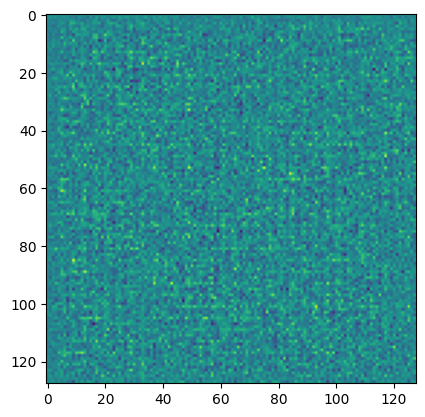

In [111]:
generator = build_generator()

noise = tf.random.normal([1, 300])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [112]:
# creating discriminator function
def build_discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [113]:
discriminator = build_discriminator()

In [114]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       9728      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       819456    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 256)       0         
                                                                 
 flatten (Flatten)           (None, 262144)           

In [115]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00270693]], shape=(1, 1), dtype=float32)


### Define Losses

In [116]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [117]:
# creating discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [118]:
# creating generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Define Optimizers

In [119]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Define the Checkpoint

In [120]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define Training Loop

In [121]:
EPOCHS = 3000
noise_dim = 300
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [122]:
def denormalize_img(img):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = 1.0 - 0.0
    to_range = 255 - 0
    scaled = np.array((img - 0.0) / float(from_range), dtype=float)
    return (0 + (scaled * to_range)).astype('uint8')

In [125]:
# # Define the SSIM function
def calculate_ssim(img1, img2):
    img1 = tf.image.convert_image_dtype(img1, tf.float32)
    img2 = tf.image.convert_image_dtype(img2, tf.float32)
    ssim = tf.image.ssim(img1, img2, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    return ssim
    


In [130]:
# initializing lists to store data
gen_loss_list = []
disc_loss_list = []
epoch_list = []
time_taken = []
ssim_list = []
avg_ssim_list = []
std_ssim_list = []

In [131]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])    
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gen_loss_list.append(gen_loss)
        disc_loss_list.append(disc_loss)

                
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [132]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(12, 12))
    
    generated_folder = r'D:/fashion-dataset/generated_img/'

    for i in range(predictions.shape[0]):
        img = denormalize_img(predictions[i, :, :, :])
        filename = os.path.join(generated_folder, f'img_{epoch:04d}_{i+1}.jpg')
        cv2.imwrite(filename, img)
        
        
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

#     plt.savefig('D:/fashion-dataset/generated_img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [134]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            images = image_batch
            train_step(images)
        
      
        
        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)
        
               
        # Calcualting the losses
        input_noise = tf.random.normal([BATCH_SIZE, noise_dim])
        fake_img = generator(input_noise, training=False)
        
        real_img = discriminator(image_batch, training=True)
        
        
        # performing SSIM evaluation
        ssim_values = calculate_ssim(images, fake_img)
        ssim_list.append(ssim_values)

        gen_loss = generator_loss(fake_img)
        disc_loss = discriminator_loss(real_img, fake_img)
        
        # Storing the losses          
        epoch_val = f'Epoch {epoch + 1}'
        time_val = time.time()-start
                
        gen_loss_list.append(gen_loss)
        disc_loss_list.append(disc_loss)
        epoch_list.append(epoch_val)
        time_taken.append(time_val)
        

#         print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print (f'Time for {epoch_val} is {time_val}')
        print(f'Discriminator Loss: {disc_loss} \nGenerator Loss: {gen_loss}')
        
#         Print and store SSIM value
        
        avg_ssim = tf.reduce_mean(ssim_list[-1])
        avg_ssim_list.append(avg_ssim)
        print(f'Average SSIM: {avg_ssim}')
        
        std_ssim = np.std(ssim_list[-1])
        std_ssim_list.append(std_ssim)
        print(f'Standard Deviation SSIM: {std_ssim}')

        # Clear the SSIM list for the next epoch
#         ssim_list.clear()
    
    
    


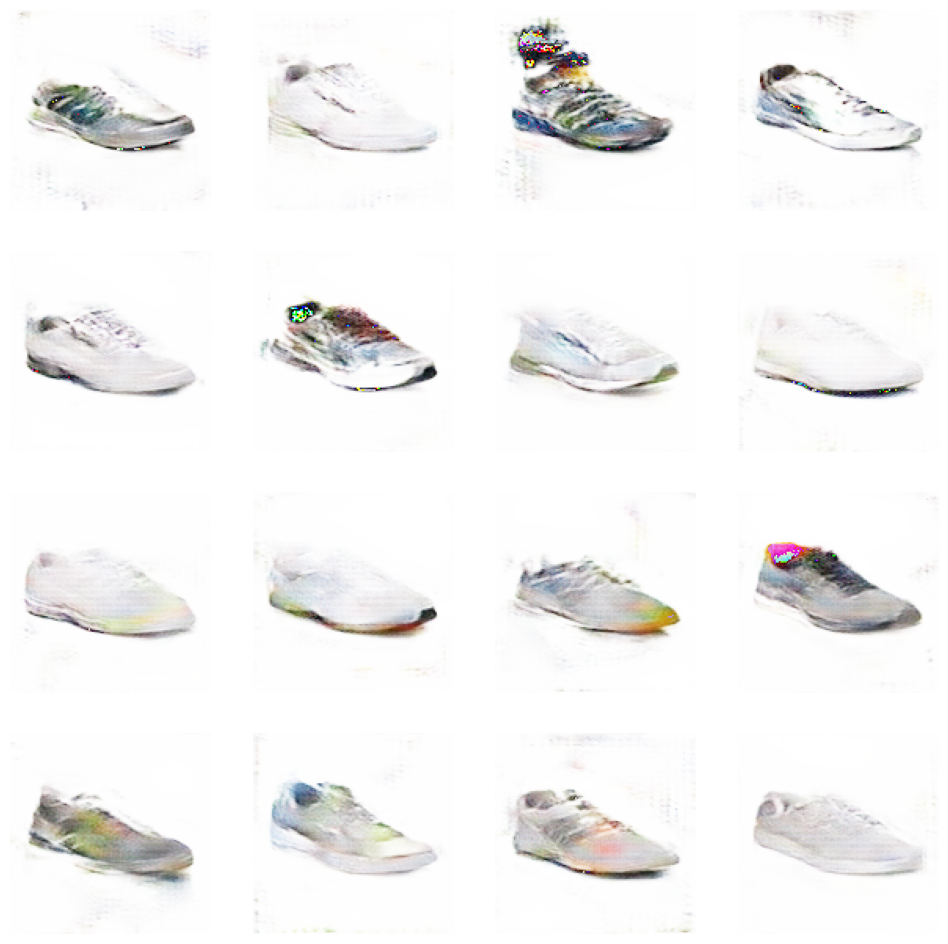

Time for Epoch 3000 is 94.74907088279724
Discriminator Loss: 1.3425695896148682 
Generator Loss: 0.3333325684070587
Average SSIM: 0.6589096188545227
Standard Deviation SSIM: 0.03794912248849869


In [137]:
train(fashion_data, EPOCHS)

In [138]:
# viewing the ssim_list
ssim_list

[<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([0.01059166, 0.0080058 , 0.00733176, 0.00975794, 0.01531939,
        0.00891872, 0.00814968, 0.00819631, 0.01241566, 0.00952925,
        0.00808665, 0.00873078, 0.010232  , 0.00780103, 0.01654202,
        0.00756282, 0.008007  , 0.01065163, 0.0134967 , 0.00935773,
        0.00792091, 0.00751868, 0.01056354, 0.01220444, 0.007976  ,
        0.01681305, 0.00855503, 0.00818484, 0.01470565, 0.01057222,
        0.01014804, 0.00715609, 0.01072749, 0.00886568, 0.00895682,
        0.00841495, 0.00886808, 0.01444333, 0.00959484, 0.01479451,
        0.01193909, 0.00951491, 0.00861776, 0.00787626, 0.00768032,
        0.01027981, 0.00800973, 0.0079177 , 0.01143545, 0.00749733,
        0.00781083, 0.00769716, 0.00725889, 0.00837892, 0.00794854,
        0.00811844, 0.00932406, 0.01241428, 0.00822479, 0.01039084,
        0.00802586, 0.00866254, 0.00714635, 0.01126737, 0.00737436,
        0.0075519 , 0.00783464, 0.00736848, 0.01063789, 0.00991124,

In [161]:
# viewing the avg_ssim_list
avg_ssim_list

[<tf.Tensor: shape=(), dtype=float32, numpy=0.009422616>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.014925033>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.019758604>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.01726916>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.012055384>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.010854495>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.01380006>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.05158159>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.051668823>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09699711>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09094578>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.067848384>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.16829711>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.25799716>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.29657903>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.33485478>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.35936892>,
 <tf.Tensor: shape=(), d

In [163]:
# Converting to numpy array
avg_ssim = np.array(avg_ssim_list)
avg_ssim

array([0.00942262, 0.01492503, 0.0197586 , ..., 0.65830743, 0.65332496,
       0.6589096 ], dtype=float32)

In [164]:
std_ssim_list

[0.002306125,
 0.003529021,
 0.0040923655,
 0.0031823788,
 0.0029010223,
 0.0032596088,
 0.0020140607,
 0.015268982,
 0.014004366,
 0.03849229,
 0.030451177,
 0.015405784,
 0.06316509,
 0.089535266,
 0.084068604,
 0.079469524,
 0.08741919,
 0.093802646,
 0.06838034,
 0.048892997,
 0.024161234,
 0.03935835,
 0.059918676,
 0.059607558,
 0.048790313,
 0.039712388,
 0.024724707,
 0.03041823,
 0.04120311,
 0.09697666,
 0.052821036,
 0.05880735,
 0.039257433,
 0.0679399,
 0.044984885,
 0.030175129,
 0.031726334,
 0.033219986,
 0.037425097,
 0.026439337,
 0.03572094,
 0.0318865,
 0.041174565,
 0.034440674,
 0.036104076,
 0.03338012,
 0.03097,
 0.041342694,
 0.05029387,
 0.03476327,
 0.04521766,
 0.082266696,
 0.058188424,
 0.03930737,
 0.03173152,
 0.031749822,
 0.032635827,
 0.035069708,
 0.030822381,
 0.046107333,
 0.03886434,
 0.046769656,
 0.03342482,
 0.037845068,
 0.05023783,
 0.045824703,
 0.029641671,
 0.066524565,
 0.04707224,
 0.033285193,
 0.035794448,
 0.055407267,
 0.042773776,
 

#### Generated Image Information

In [147]:
# Creating a dataframe for the loss evaluations
evaluation_df = pd.DataFrame(columns=['Epoch', 'Time', 'Discriminator Loss', 'Generator Loss'])
evaluation_df['Epoch'] = epoch_list
evaluation_df['Time'] = time_taken
evaluation_df['Discriminator Loss'] = disc_loss_list[-3000:]
evaluation_df['Generator Loss'] = gen_loss_list[-3000:]

In [148]:
evaluation_df

Epoch       Time                              Discriminator Loss  \
0        Epoch 1  91.451727  tf.Tensor(0.70154697, shape=(), dtype=float32)   
1        Epoch 2  93.196818  tf.Tensor(0.70238644, shape=(), dtype=float32)   
2        Epoch 3  92.576681   tf.Tensor(0.7144874, shape=(), dtype=float32)   
3        Epoch 4  97.399137  tf.Tensor(0.74177754, shape=(), dtype=float32)   
4        Epoch 5  99.556996   tf.Tensor(0.7693358, shape=(), dtype=float32)   
...          ...        ...                                             ...   
2995  Epoch 2996  93.364140   tf.Tensor(1.3988645, shape=(), dtype=float32)   
2996  Epoch 2997  92.368062   tf.Tensor(1.4420298, shape=(), dtype=float32)   
2997  Epoch 2998  95.270125   tf.Tensor(1.4021535, shape=(), dtype=float32)   
2998  Epoch 2999  94.792129    tf.Tensor(1.352165, shape=(), dtype=float32)   
2999  Epoch 3000  94.749071   tf.Tensor(1.3425696, shape=(), dtype=float32)   

                                      Generator Loss  
0     tf.Tensor(0.68961996, shape=(), dtype=float32)  
1       tf.Tensor(0.684684, shape=(), dtype=float32)  
2      tf.Tensor(0.6733668, shape=(), dtype=float32)  
3      tf.Tensor(0.6505264, shape=(), dtype=float32)  
4     tf.Tensor(0.63156664, shape=(), dtype=float32)  
...                                              ...  
2995  tf.Tensor(0.33379424, shape=(), dtype=float32)  
2996  tf.Tensor(0.33212298, shape=(), dtype=float32)  
2997  tf.Tensor(0.33198446, shape=(), dtype=float32)  
2998   tf.Tensor(0.3334687, shape=(), dtype=float32)  
2999  tf.Tensor(0.33333257, shape=(), dtype=float32)  

[3000 rows x 4 columns]

In [149]:
evaluation_df['Discriminator Loss'] = evaluation_df['Discriminator Loss'].apply(lambda x: np.array(x))
evaluation_df['Generator Loss'] = evaluation_df['Generator Loss'].apply(lambda x: np.array(x))

In [150]:
evaluation_df

Epoch       Time  Discriminator Loss  Generator Loss
0        Epoch 1  91.451727            0.701547        0.689620
1        Epoch 2  93.196818            0.702386        0.684684
2        Epoch 3  92.576681            0.714487        0.673367
3        Epoch 4  97.399137            0.741778        0.650526
4        Epoch 5  99.556996            0.769336        0.631567
...          ...        ...                 ...             ...
2995  Epoch 2996  93.364140            1.398865        0.333794
2996  Epoch 2997  92.368062            1.442030        0.332123
2997  Epoch 2998  95.270125            1.402153        0.331984
2998  Epoch 2999  94.792129            1.352165        0.333469
2999  Epoch 3000  94.749071            1.342570        0.333333

[3000 rows x 4 columns]

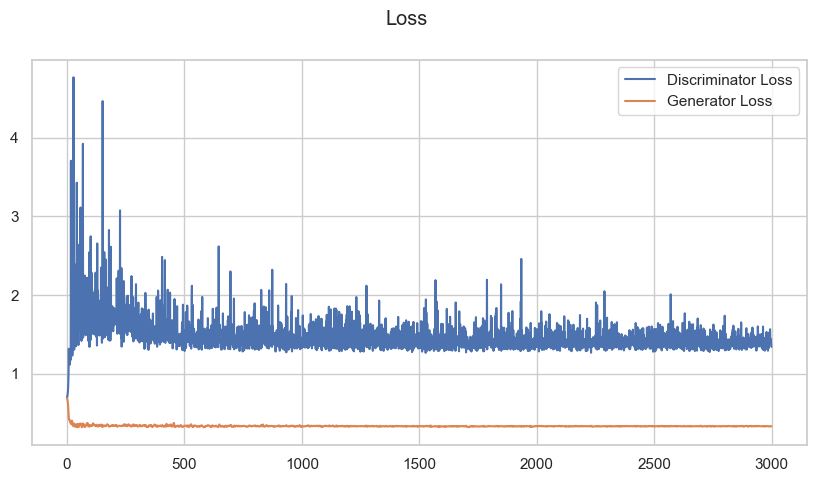

In [151]:
# Set up Seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
plt.suptitle('Loss')
plt.plot(evaluation_df['Discriminator Loss'], label='Discriminator Loss')
plt.plot(evaluation_df['Generator Loss'], label='Generator Loss')
plt.legend()
plt.show()

### Graph of Time vs Discriminator Loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


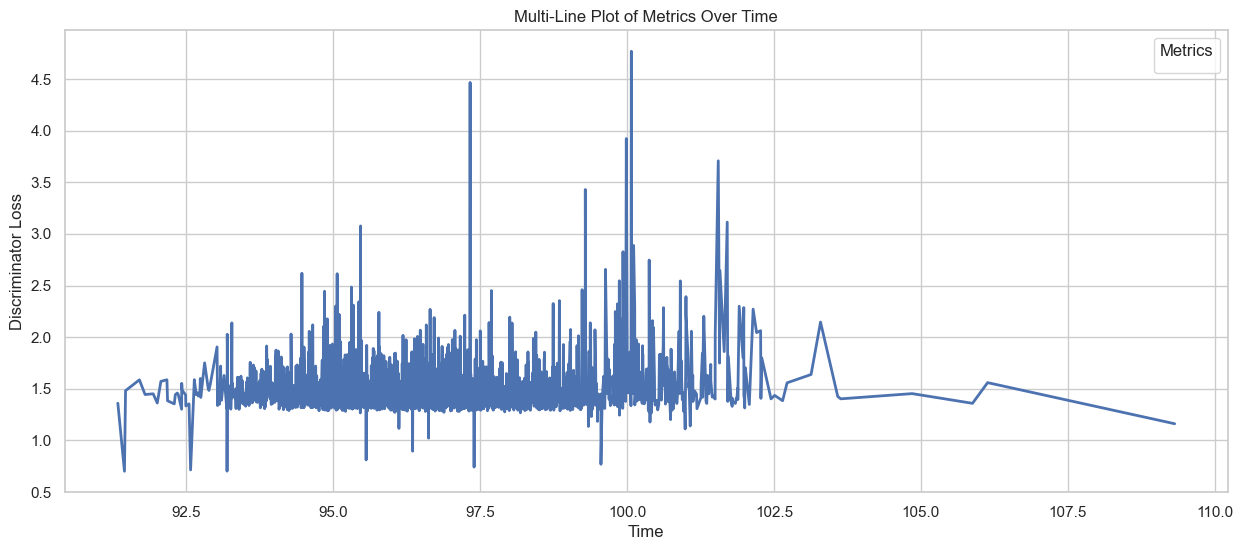

In [152]:

# Set up Seaborn
sns.set(style="whitegrid")

# Create a multi-line plot using Seaborn
plt.figure(figsize=(15, 6))
sns.lineplot(x='Time', y='Discriminator Loss', data=evaluation_df, linewidth=2)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Discriminator Loss')
plt.title('Multi-Line Plot of Metrics Over Time')

# Display the plot
plt.legend(title='Metrics', loc='upper right')
plt.show()


### Graph of Time vs Generator Loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


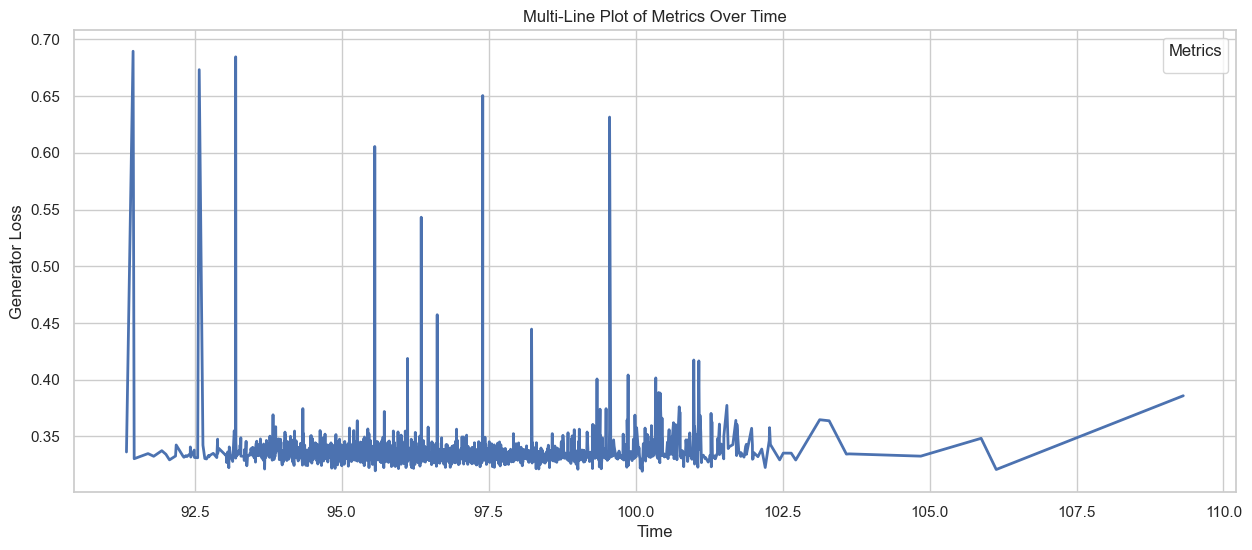

In [153]:
# Set up Seaborn
sns.set(style="whitegrid")

# Create a multi-line plot using Seaborn
plt.figure(figsize=(15, 6))
sns.lineplot(x='Time', y='Generator Loss', data=evaluation_df, linewidth=2)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Generator Loss')
plt.title('Multi-Line Plot of Metrics Over Time')

# Display the plot
plt.legend(title='Metrics', loc='upper right')
plt.show()


### Gini Evaluation

In [154]:
def gini(img_folder):
    gini_eval_list = []     
    for filename in os.listdir(img_folder):
        image = imread(img_folder + filename)
        image = image.astype(float)
    
        """Calculate the Gini coefficient of a numpy array."""

        image = image.flatten() #all values are treated equally, arrays must be 1d
        if np.amin(image) < 0:
            image -= np.amin(image) #values cannot be negative
        image += 0.0000001 #values cannot be 0
        image = np.sort(image) #values must be sorted
        index = np.arange(1,image.shape[0]+1) #index per array element
        n = image.shape[0]#number of array elements
        
        gini_coef = ((np.sum((2 * index - n  - 1) * image)) / (n * np.sum(image))) #Gini coefficient
        gini_eval_list.append(gini_coef)
    return(gini_eval_list)

In [155]:
output_gini = gini('D:/fashion-dataset/Generated Images/')

In [156]:
input_gini = gini('D:/fashion-dataset/images/resized_sneakers_2/')

In [157]:
# Getting the average of the input and output gini coefficients
avg_input_gini = np.mean(input_gini)
avg_output_gini = np.mean(output_gini)

# Getting the standard deviation of the input and output gini coefficients
std_input_gini = np.std(input_gini)
std_output_gini = np.std(output_gini)

print(f'For the input images, the average is {avg_input_gini}, while the standard deviation is {std_input_gini}')
print(f'For the output images, the average is {avg_output_gini}, while the standard deviation is {std_output_gini}')

For the input images, the average is 0.10698845421236669, while the standard deviation is 0.04412158493963692
For the output images, the average is 0.05064136025127438, while the standard deviation is 0.03008852941328258


In [158]:
# Getting the Z-Test for the gini evaluation
gini_z_test = (avg_input_gini - avg_output_gini)/(np.sqrt((std_input_gini**2)+(std_output_gini**2)))
gini_z_test

1.055101363052334

In [165]:
len(avg_ssim_list)

3000